<a href="https://colab.research.google.com/github/alex-muci/small-projects/blob/master/A_Hands_On_Forecasting_Guide_From_Theory_to_Practice_%7C_Khipu_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Hands-On Forecasting Guide: From Theory to Practice | Khipu 2023

Welcome to the Code Camp, please visit [github.com/tryolabs/khipu-2023](https://github.com/tryolabs/khipu-2023) or scan the QR to get access to this colab notebook.

<center>
<img src="https://drive.google.com/uc?export=view&id=1Qt_zmitkRnkmpsEQbieIBe5jbDx1xUKD" width="50%"/>
</center>

### Abstract
> Forecasting, the prediction of future events from past data, is central to decision-making in virtually all technical domains. For instance, predicting product sales in retail, forecasting energy demand, or anticipating customer churn, all have tremendous value across different industries. However, the landscape of forecasting techniques is as diverse as it is useful, and different techniques and expertise are adapted to different types and sizes of data.
>
> In this hands-on workshop led by experts from Tryolabs and Google, we give an overview of forecasting concepts, methods, and practical applications on the M5 forecasting challenge. In the context of forecasting, we’ll walk you through the data exploration, data preparation, feature engineering, statistical (e.g., STL, ARIMA) and machine learning (e.g., decision forests) modeling, meta-modeling (e.g., hierarchical and relational modeling, ensembles, resource models), and how to safely evaluate such temporal models.
>
> We conclude the session with a discussion and a list of reading materials to learn more about forecasting. Join us for a fun and interactive workshop hosted by Tryolabs and Google!


<img src="https://i.imgur.com/XppDOZz.png"/>

# Agenda

- Intro to forecasting
- M5 dataset
- Evaluation metric
- Modeling
  - Baseline
  - SARIMA
  - Tabular with GBDT
- Feature engineering
  - Calendar features
  - Moving statistics
  - Special events
- Further resources
- Conclusions

# Setup


### ⚠️ Before moving on ⚠️
**Please, make a copy of this notebook into your own Drive: ```File -> Save a copy in Drive```**

---

Run the following cell to install and load the libraries used during this session.

<font color="red"> Note: Run cells before expanding them.

In [ ]:
#@title Install dependencies

%%shell
pip install -U -q pandas
pip install -U -q matplotlib
pip install -U -q seaborn
pip install -U -q statsmodels
pip install -U -q tensorflow_decision_forests
apt-get -qq install -y graphviz && pip install pydot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 50.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Imports

# TODO: use black to format the entire notebook
import gc
import re
from collections import defaultdict
from typing import Dict, Tuple, List, Optional, NamedTuple, Union

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_decision_forests as tfdf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
import pydot
from IPython.display import Image

plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 3)

# Intro to Forecasting

Forecasting is a crucial aspect of many industries and fields, including finance, healthcare, manufacturing, and transportation. It helps organizations make informed decisions by anticipating future trends and outcomes, which can improve efficiency and reduce costs.

With this technique, we can predict future events from past data and existing knowledge. Following are example of forecasting problems:

- Forecast next year's sales
- Forecast stocks price
- Forecast energy demand
- Forecast next week's weather
- Forecast the onset of cancer
- Forecast the score of a soccer match
- Forecast the propability of customer churn

<br>
<center>
<img src="https://drive.google.com/uc?export=view&id=1Jnq3Lat4wHaCQX9tfbXFM3IiVXVjheAH"/>
</center>
<br>

A forecast is the source of knowledge that makes planning and decision-making possible. For example:

- Forecasting the weather at sea to plan the ship's routes, and save on fuel and maintenance.
- Forecasting next year's sales for a car manufacturer to plan for electronic component purchases.
- Forecasting the onset of cancer allows for early treatment and a higher chance of recovery.


## How to forecast?

The landscape of forecasting techniques is as diverse as it is useful. Different techniques exist for different types (e.g., time sequences, time series, transactions) and amounts (e.g., 10 observations, 10B observations) of data, as well as for different type of predictions.

On small time series dataset, statistical models such as [ARIMA](https://otexts.com/fpp3/arima.html) and [Exponential Smoothing](https://otexts.com/fpp3/expsmooth.html) are well suited. On larger datasets where more complex models can be learned, deep learning and [decision forests](https://en.wikipedia.org/wiki/Random_forest) methods are commonly used. In this session, we will demonstrate the use of one statistical model (ARIMA) and a more powerful general purpose model (decision forests).

Data-preparation plays an important role in forecasting. Feature engineering is useful to inject expert knowledge in models when only a small amount of data is available.

For example, [heart rate variability](https://en.wikipedia.org/wiki/Heart_rate_variability) is predictive of some cardiac events. If operating on electrocardiogram data, pre-computing the heart rate variability is beneficial for many forecasting tasks.

Feature engineering is also important on large datasets. It is used to extend the power of expression of forecasting models. For example, while a [feed-forward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) is not able to consume [relational data](https://en.wikipedia.org/wiki/Relational_database), preprocessing (called "flattening" in this case) relational data into tabular data can be beneficial for the modeling task.

In this session, we will demonstrate several feature engineering methods for forecasting.


## Forecasting on Timeseries

Let's start simple. A (univariate) time series (TS) is a sequence of numerical values sampled at a constant rate (e.g., once a day). The only variable is the time, often represented by 𝑡.

A TS can be represented as a plot where the horizontal axis is the time, and the vertical axis is the TS value.

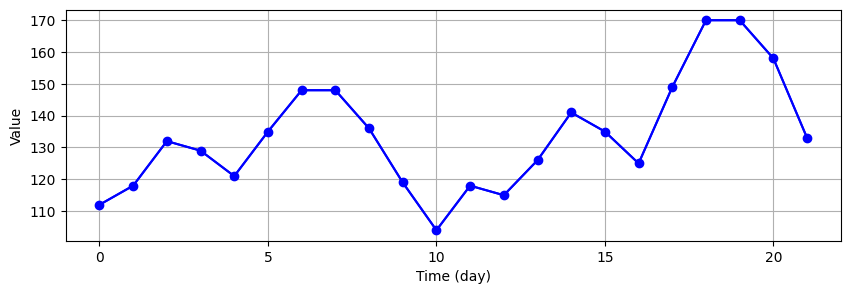

In [ ]:
#@title Univariate time series
values = [
    112,
    118,
    132,
    129,
    121,
    135,
    148,
    148,
    136,
    119,
    104,
    118,
    115,
    126,
    141,
    135,
    125,
    149,
    170,
    170,
    158,
    133
]

plot_xlim = [-1, len(values)]

plt.figure(figsize=(10, 3))
plt.plot(values, color="blue")
plt.plot(values, marker="o", color="blue")
plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.grid()
plt.show()

A forecast made at time $t$ (informally referred as "now") is the prediction of some of the future observations $\{ s[t'] \ | \ t' > t \}$ using past observations $\{ s[t''] \ | \ t'' \le t \}$, where $s$ is a univariate time series.

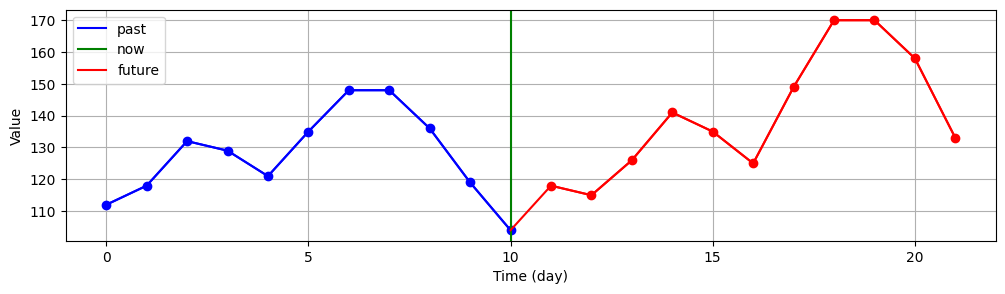

In [ ]:
#@title Forecast
past_data = [112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104]
past_time = [i for i in range(len(past_data))]
now_time = len(past_time) - 1
future_data = [118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133]
future_time = [i + len(past_time) for i in range(len(future_data))]

plot_xlim = [-1, future_time[-1] + 1]


plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")
plt.axvline(x=now_time, color="green", label="now")
plt.plot(future_time, future_data, color="red", marker="o")
# add last past value in order to join future and past line
plt.plot([past_time[-1]] + future_time, [past_data[-1]] + future_data, color="red", label="future")


plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

**To go deeper:** The time $t$ of an observation is not necessarily the time of occurrence of the observed phenomenon. It can also be the time where this observation becomes available for decision making. For example, if the [Curiosity mars rover](https://en.wikipedia.org/wiki/Curiosity_(rover)) makes a measurement at a certain time, this measurement can only be used for decision making on earth between 5 and 20 minutes later because of the speed of light propagation.

### Next step forecast

The simplest and most direct type of forecasting is the "next step" prediction. The objective is to predict the next value $s[t+1]$ (orange dot).

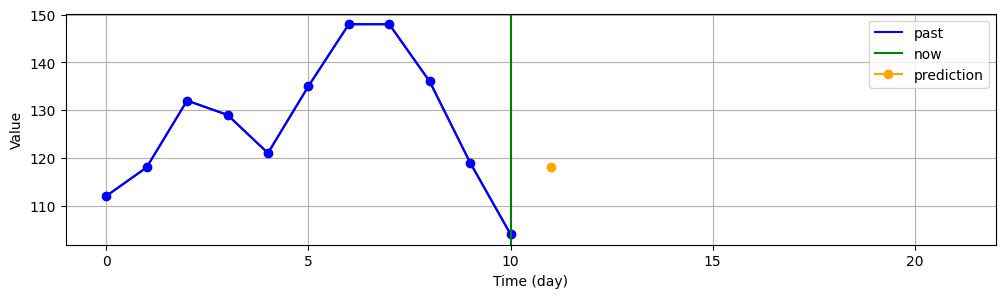

In [ ]:
#@title
plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")
plt.axvline(x=now_time, color="green", label="now")
plt.plot(future_time[0], future_data[0], color="orange", marker="o", label="prediction")

plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

The prediction can be a single point such as the expected value, a distribution, or a statistic of this distribution (e.g. first quantile). It is common to predict both the expected value and the confidence boundaries on the prediction.

**Example of next-step forecast:** How much product will be solved tomorow?

### Multi-steps forecast

More complex is the forecasting of the next $h>1$ steps: $\{ s[t+i]\ |\ i \in [1, h] \}$

*Note: $h$ stands for "horizon".*

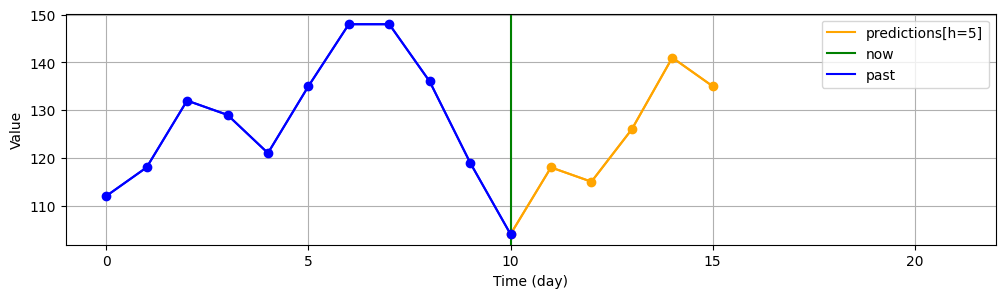

In [ ]:
#@title
#adding last past data point to draw line between past data and prediction
predictions = [past_data[-1]] + future_data[:5]
predictions_time = [past_time[-1]] + future_time[:5]

plt.plot(predictions_time, predictions, color="orange", label="predictions[h=5]")
plt.plot(predictions_time, predictions, color="orange", marker="o")
plt.axvline(x=now_time, color="green", label="now")
plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")

plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

### Aggregated forecast

In some cases, predicting the aggregated values of the next steps is easier and equally useful for planning.

For example, we can predict the sum or the maximum of the TS in the next h days:
$$
\sum_{i=1}^h s[t+i]
$$
or
$$
\max_{i \in [1, h]} s[t+i]
$$

**Concrete example:** predict the sum of sales in the next 28 days.





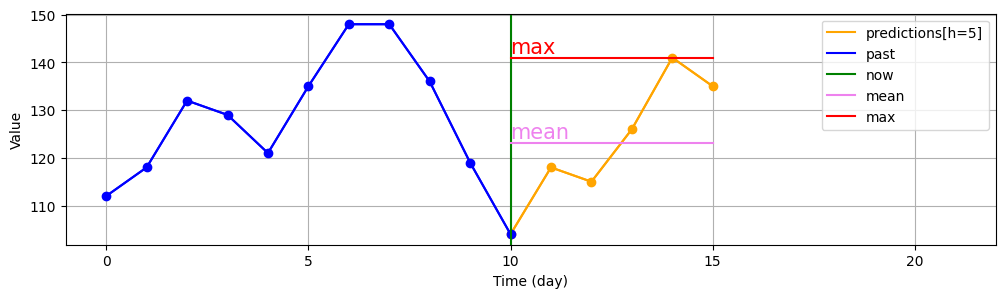

In [ ]:
#@title
# calculate mean and max of predictions
mean = np.mean(predictions)
max = np.max(predictions)

plt.plot(predictions_time, predictions, color="orange", label="predictions[h=5]")
plt.plot(predictions_time, predictions, color="orange", marker="o")
plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")
plt.axvline(x=now_time, color="green", label="now")

# plot mean and max in predictions time
plt.plot(
    predictions_time, [mean] * len(predictions_time), color="violet", label="mean"
)

# ADD mean title above the mean line
plt.text(
    predictions_time[0],
    mean + 1,
    "mean",
    fontsize=15,
    color="violet",
)

plt.plot(predictions_time, [max] * len(predictions_time), color="red", label="max")

# ADD max title above the max line
plt.text(
    predictions_time[0],
    max + 1,
    "max",
    fontsize=15,
    color="red",
)

plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

### Conditional forecast

Finally, it is sometimes enough to only predict a condition on the data. For example, we can predict if the value will be greater than a threshold $\tau$ in the next $h$ steps: $\ s[t+i] \ge \tau$ for $i \in [1,h]\ $.

**Concrete example:** Will the heart rate of the patient go under 5 beats per seconds in the next 6h.


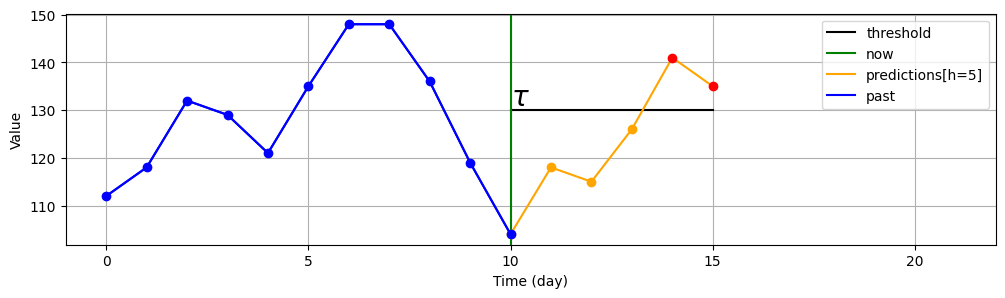

In [ ]:
#@title
tau = 130

plt.text(
    predictions_time[0],
    tau + 1,
    r"$\tau$",
    fontsize=20,
    color="black",
)

# draw horizontal line in tau in predictions time
plt.plot(
    predictions_time,
    [tau] * len(predictions_time),
    color="black",
    label="threshold",
)

plt.axvline(x=now_time, color="green", label="now")

# highlight predictions above tau

plt.plot(predictions_time, predictions, color="orange", label="predictions[h=5]")
for i in range(len(predictions)):
    if predictions[i] > tau:
        plt.plot(
            predictions_time[i],
            predictions[i],
            color="red",
            marker="o",
        )
    else:
        plt.plot(
            predictions_time[i],
            predictions[i],
            color="orange",
            marker="o",
        )

plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")

plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

**Note:** The prediction of aggregated and condition forecasting can be computed from multi-step forecasting predictions. However, multi-step forecasting can require more data and more complex modeling than aggregated/conditional forecasting. In such a case, forecasting aggregate/conditional forecasting directly can be more efficient.

# Execution mode

For faster iteration during this codecamp, we make available three `EXECUTION_MODE`s that control the speed and quality of some of the computation. The available modes are:

- `EXECUTION_MODE="TOY"`: Very fast execution, poor results.
- `EXECUTION_MODE="MINI"`: Fast execution, cells run in 3 minutes maximum, decent results. We will be using this mode during this codecamp.
- `EXECUTION_MODE="FULL"`: Slow execution, best results. We make this mode available for attendees that want to give it a go at home.


In [ ]:
EXECUTION_MODE = "MINI"

# Here you can see the available config and their parameter values.
#
# num_trees: Number of decision trees trained in each model.
# num_items / num_stores: Number of selected items /stores in the dataset.
# num_horizons: How many steps to forecast in multi-step forecast.

available_configs = {
    "TOY": {
        "num_trees": 20,
        "num_items": 3,
        "num_stores": 3,
        "num_horizons": 2,
    },
    "MINI": {
        "num_trees": 75,
        "num_items": 5,
        "num_stores": 5,
        "num_horizons": 7,
    },
    "FULL": {
        "num_trees": 1000,
        "num_items": None,
        "num_stores": None,
        "num_horizons": 28,
    }
}

config = available_configs[EXECUTION_MODE]
print(f"{config=}")

config={'num_trees': 75, 'num_items': 5, 'num_stores': 5, 'num_horizons': 7}


# The data: The M5 Competition

The [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview) is the 2020 instance of the [Makridakis Forecasting Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions). The objective of this competition is to forecast the next 28 days of sales of 3k individual items in 10 different Walmart stores.

Walmart's data possesses a strong hierarchical structure, since each item belongs to a certain category and department, and each store to a certain state.

This means that, besides the 30k individual low-level time series corresponding to the daily sales of a specific item in a specific store (which we'll be referring to as an "item-store" or "level 12" time series), the data can be aggregated in multiple ways to generate a total of 42,840 time series to be forecasted, as shown in the images below.

In this notebook, we will stick to only predicting the sales of item-store series, though the data's hierarchical structure will come in handy in the feature engineering stage.

Details such as the [competition's guide](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf) and [Makridakis' analysis of the winning entries](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions) are available online.

<img src="https://drive.google.com/uc?export=view&id=1ssPXZf1uVtNnbbjaaEEqpx4ZmhQobmSE" width=800/>
<img src="https://drive.google.com/uc?export=view&id=1jBT0pPcSWf8n5bJkZ1G7y_glrQcrYKoI" width=800/>

Source: [The M5 Accuracy competition: Results, findings and conclusions](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions)

## Load the dataset

Let's download and unzip the competition's dataset.

In [ ]:
#@title
# download and unzip data
%%shell
wget -q -O data.zip 'https://docs.google.com/uc?export=download&id=1NYHXmgrcXg50zR4CVWPPntHx9vvU5jbM&confirm=t'
unzip -o data.zip

Archive:  data.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


The dataset is composed of 5 csv files:

- `sales_train_evaluation`: The history of item sales.
- `calendar.csv`: Dates and calendar events related to the sales.
- `sell_prices.csv`: The history of the item prices. **Not used in this codecamp.**
- `sales_train_validation`: Another set of sales. **Not used in this codecamp.**
- `sample_submission`: An example of submission for the competition. **Not used in this codecamp.**


Following are the column names used in the dataset. To minimize errors, we recommend using these variables.

In [ ]:
# Identifier of a sales timeseries.
# This is the series of sales values of a given ITEM, in a given STORE.
ID = "id"

ITEM = "item_id" # Identifier of the item
STORE = "store_id" # Identifier of the store
DEPT = "dept_id" # Identifier of the item's department
CAT = "cat_id" # Identifier of the item's category
STATE = "state_id" # Identifier of the store's state

DAY = "d" # Identifier of the day, sequential number from day 1 to 1941
DATE = "date" # The calendar date each day corresponds to
SALES = "sales" # The sales value for an ID on a certain DAY
PRED = "sales_pred" # The predicted sales value for an ID on a certain DAY

Let's load and take a look at the historical sales in  `sales_train_evaluation.csv`. Each row contains the sales of a item+store pair (i.e. for a given item in a given store). Sales are aggregated per day. Each day, indexed between 1 and 1914 (5+ years), is stored in a different column.

**Note:** Most of the values in this dataset are strings (e.g. stores are `CA_1`, `CA_2`, ...) with few unique values. To limit the memory footprint, we will load those columns as [Pandas' categorical dtype](https://pandas.pydata.org/docs/user_guide/categorical.html).

In [ ]:
# load sales data
raw_sales = pd.read_csv(
    'sales_train_evaluation.csv',
    dtype={
        ID: "category",
        ITEM: "category",
        DEPT: "category",
        CAT: "category",
        STORE: "category",
        STATE: "category",
    }
)

# print the memory footprint of the dataset
print("Memory usage")
print(raw_sales.info())

# print the first 5 rows i.e. the first 5 item & store entries
print("First 5 rows")
raw_sales.head()

Memory usage
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int64(1941)
memory usage: 453.1 MB
None
First 5 rows


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


##  Explore the dataset

Looking at the data is the first step of any forecasting exercise. Although we won't do a thorough exploratory data analysis in this codecamp, lets take a quick look at some plots to get a grasp on the data we're dealing with.

Let's plot the first three series:

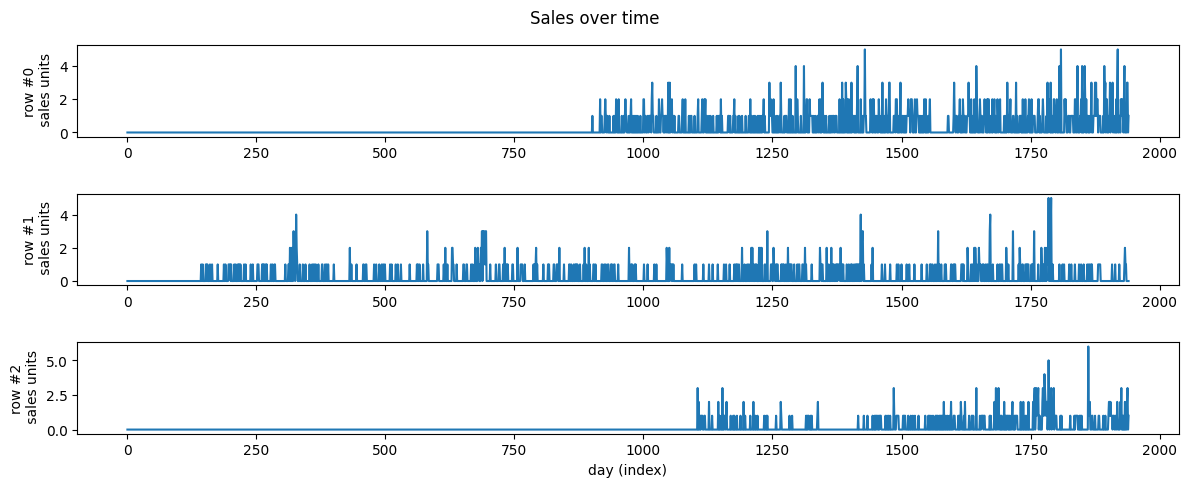

In [ ]:
#@title
num_plots = 3
plt.figure(figsize=(12,2 * num_plots))

d_cols = list(raw_sales.filter(regex="d_"))

for row_idx in range(num_plots):
  # "ts" refers to "timeseries".
  sales_ts = raw_sales.iloc[row_idx][d_cols].to_numpy()

  plt.subplot(num_plots+1, 1, row_idx+1)
  plt.plot(sales_ts)
  plt.ylabel(f"row #{row_idx}\n sales units")

plt.suptitle("Sales over time")
plt.xlabel("day (index)")
plt.tight_layout(h_pad=1)
plt.show()

### Question

1. What insights or conclusions do you draw from the plots above?

In [ ]:
#@title Solution

# 1. Not all products started being sold at the same time. They usually start with 0 sales units.
# 2. Row #0, #1 and #3 show really different pattern. Row #0 and #2 look quite irregular. Row #1 shows some peaks every 365 days approx.
# 3. Row #2 show a period, which seems to be an out-of-stock period, between day 1250 and 1500.
# 4. Sales seem very sporadic for row #1, with several periods of 0 sales.
# 5. any others?

Let's do a zoom in on the last 28 days for a single item:

<Axes: title={'center': 'HOBBIES_1_001_CA_1_evaluation'}>

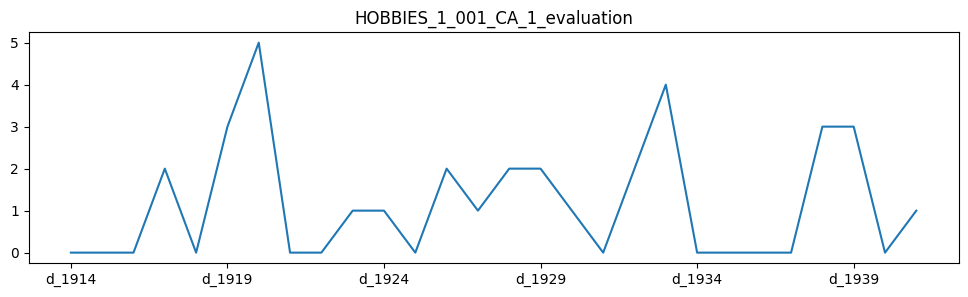

In [ ]:
example_id = "HOBBIES_1_001_CA_1_evaluation"

# select the sales of our example item
example_ts = raw_sales[(raw_sales[ID] == example_id)][d_cols].squeeze()

# plot the last 28 days of sales.
example_ts[-28:].plot.line(title=example_id)

At the item-store level, sales can be very sparse for non popular items. For example, in the plot above, there were no sales in about half the displayed days.

It can be interesting to look at aggregated sales according to different dimensions. For example, the following plot shows the sales for the store `CA_1`, once you've completed the exercise of filling the code for `aggregate_sales_by_store`.

### Exercise

In [ ]:
def aggregate_sales_by_store(sales : pd.DataFrame) -> pd.DataFrame:
  """ Aggregate the sales units by store."""

  # TODO: add your code here #
  # Hint: What aggregation function would you use for sales units?

  return sales_by_store

In [ ]:
#@title Solution

def aggregate_sales_by_store(sales):
  """ Aggregate the sales units by store. """

  sales_by_store = (
      raw_sales
      .groupby([STORE])
      .agg("sum", numeric_only=True)
      .reset_index()
  )

  return sales_by_store


<Axes: >

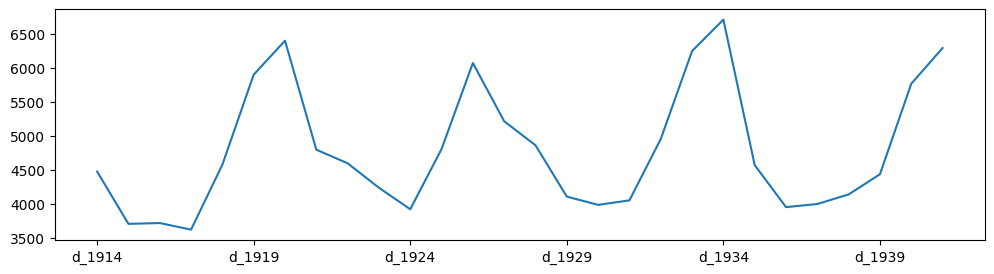

In [ ]:
# plot the last 28 days of sales of the store CA_1
sales_by_store = aggregate_sales_by_store(raw_sales)
sales_by_store[sales_by_store[STORE] == "CA_1"][d_cols].squeeze()[-28:].plot.line(x=DATE, y=SALES)

As we can see, the store level time series follows a much stronger and steadier pattern that the item-store level ones - and would therefore be much easier to forecast.

Lets take a look at the number of average daily sales for each ID.

<Axes: >

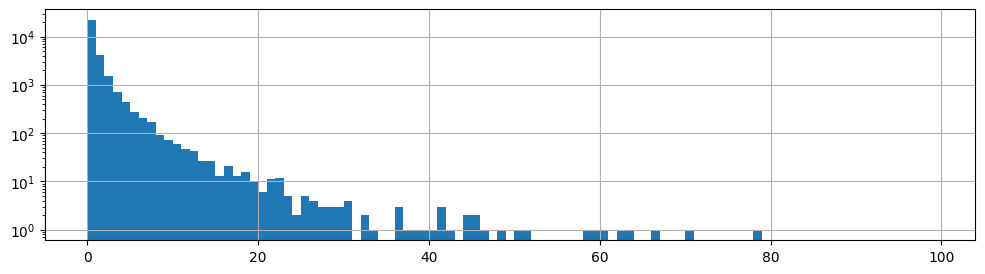

In [ ]:
# plot histogram of item/store average daily sales
raw_sales[d_cols].mean(axis=1).squeeze().hist(log=True, bins=range(100))

## Trend and Seasonality

**Trend**: direction or tendency of the time series during a long period of time.

**Seasonality**: patterns or variations that repeat at a regular interval.

This dataset is about sales made by people, and usually, human behavior exhibits cycles. The most notables interval of these cycles are 1 day, 1 week, 1 month, and 1 year.

The next plot shows the **sum of all the sales over the last 2 months**. At this scale, the 7 days seasonality is very clear.

<Axes: >

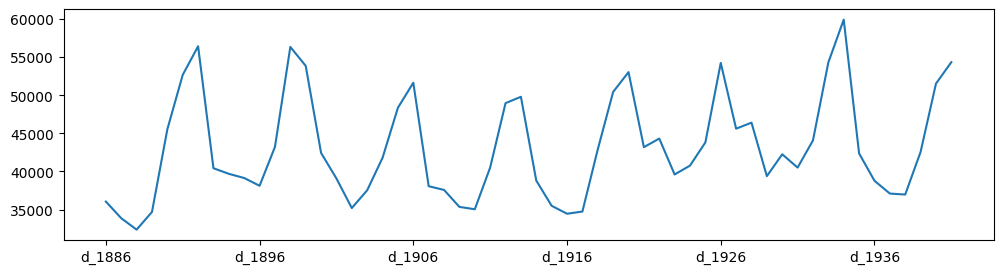

In [ ]:
#@title
# plot the sum of all the sales over the last 2 months.
sales_global = raw_sales[d_cols].sum(axis=0).squeeze()
sales_global[-56:].plot.line()

Now, if we zoom-out and plot sales over the last 5 years, the 7 days seasonality is visible but hard to see because its very compressed.

<Axes: >

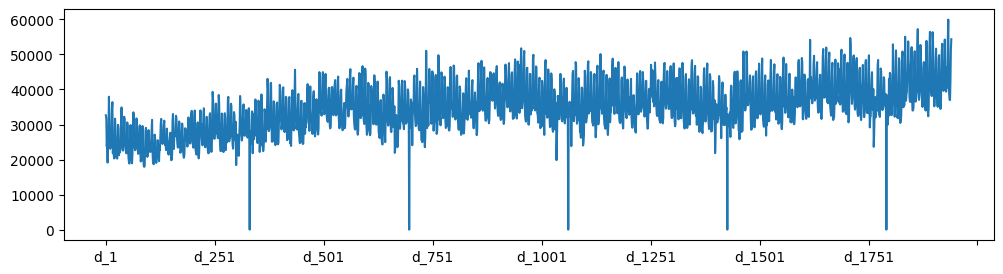

In [ ]:
# plot the daily global sum of sales
sales_global.plot.line()

We can also see both some kind of yearly seasonality, and a global upwards trend.

For example in 2011, the daily sales were around 25k, while they are around 45k in 2016. An easier way to visualize these yearly patterns is to apply a moving average on the time series (i.e., swapping each datapoint in the series for the average of a fixed amount of datapoints around it).

<Axes: >

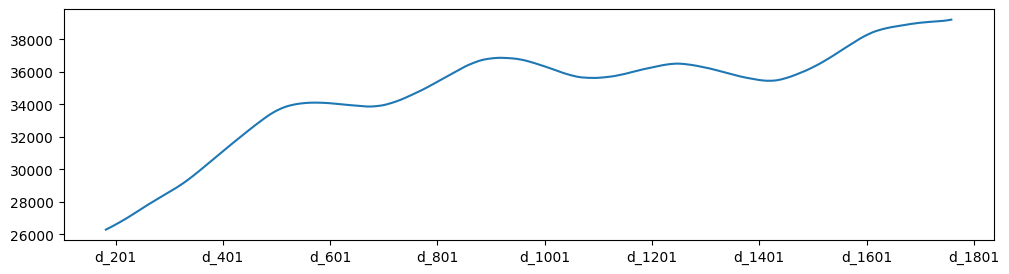

In [ ]:
sales_global.rolling(365, center=True, win_type="triang").mean().plot.line()

We can see that sales are globally increased during those 5 years. Keep in mind though that, as we saw before, some products started being sold much later than `d_1`, so this global upwards trend doesn't necessarily indicate a similar trend in the item-store level time series.

Instead of trying to visualize these components of our time series manually, we could use a method such as **STL descomposition** (Seasonal and Trend decomposition using Loess), which decomposes a times series into trend, seasonal, and residual components.

More information about STL can be found [here](https://otexts.com/fpp3/stl.html).

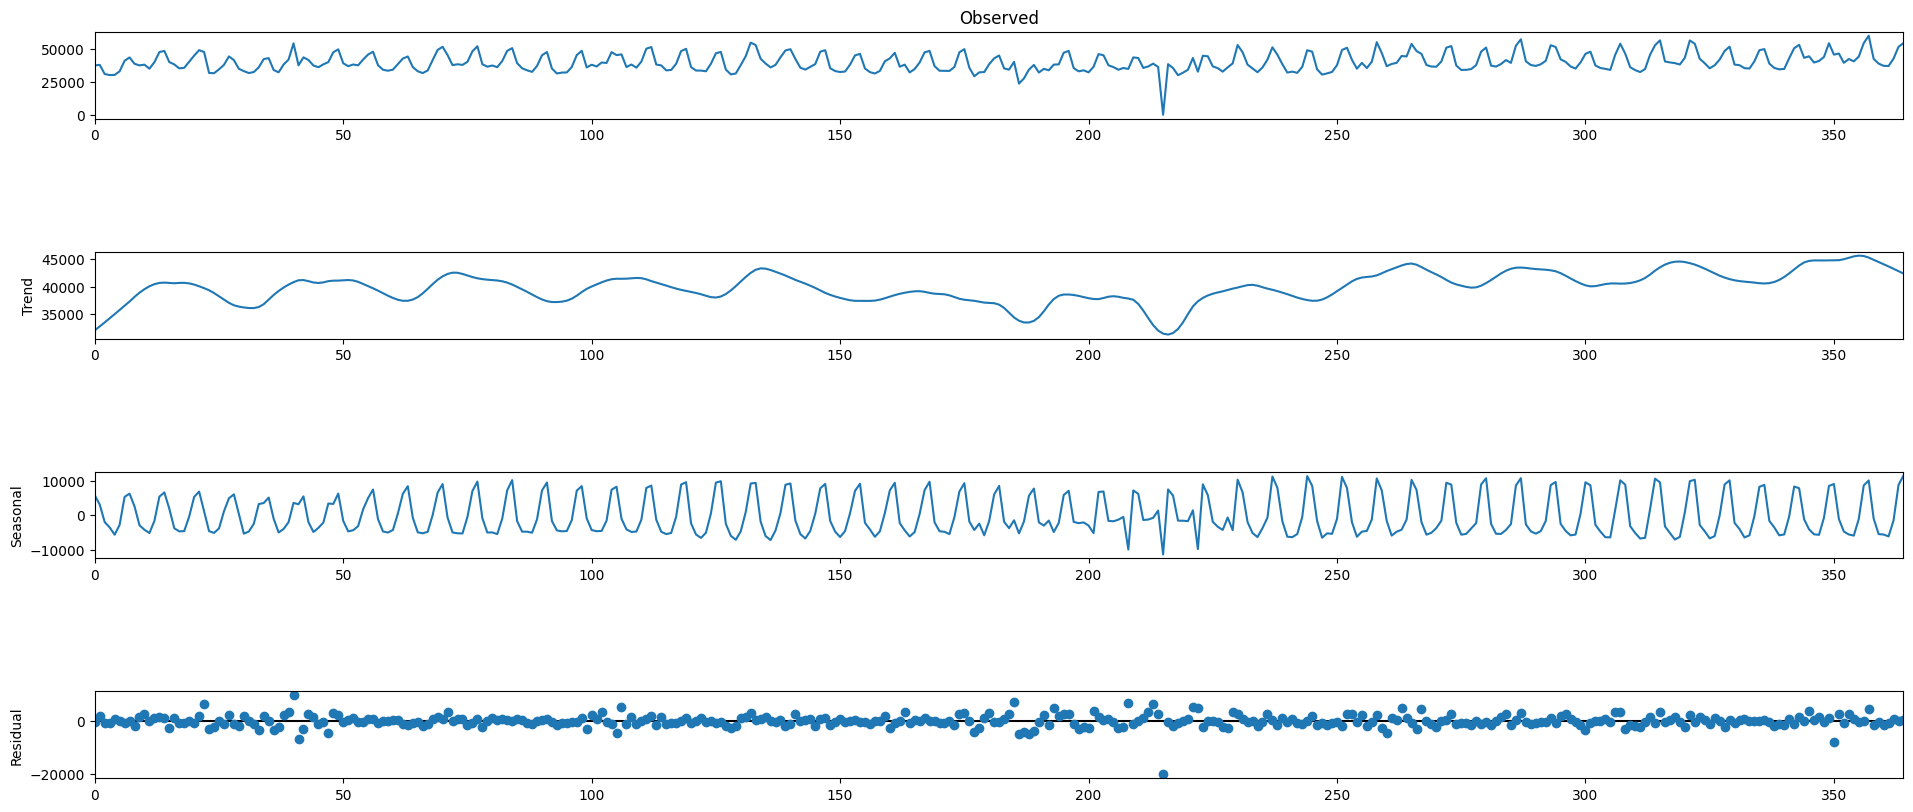

In [ ]:
stl = STL(sales_global[-365:].to_numpy(), period=7)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 10)

# Data preparation

## Select a subset of products

Having this much data is any scientist's dream, but not ideal for quickly iterating over new approaches in what's left of this notebook.

Let's select a subset of the 5 best selling products and stores!

In [ ]:
#@title
# compute total sales by summing over all daily sales columns
d_columns = list(raw_sales.filter(regex='d_'))
total_sales = raw_sales[d_columns].sum(axis=1)

# find best selling items
best_selling_items = (
    raw_sales
    .assign(total_sales=total_sales)
    .groupby(ITEM)
    .sum(numeric_only=True)
    .reset_index()
    .sort_values(by="total_sales", ascending=False)
    .iloc[:config["num_items"]][ITEM]
    .tolist()
)
print(f"\n{best_selling_items=}")

# find best selling stores
best_selling_stores = (
    raw_sales
    .assign(total_sales=total_sales)
    .groupby(STORE)
    .sum(numeric_only=True)
    .reset_index()
    .sort_values(by="total_sales", ascending=False)
    .iloc[:config["num_stores"]][STORE]
    .tolist()
)
print(f"\n{best_selling_stores=}")

# select only datapoints that correspond to those items and stores
raw_sales_subset = raw_sales[
    raw_sales[ITEM].isin(best_selling_items) &
    raw_sales[STORE].isin(best_selling_stores)
]

# refresh values present in the ID and ITEM categorical columns
# which now have fewer unique values
raw_sales_subset = raw_sales_subset.assign(
    **{
        ID: raw_sales_subset[ID].astype("object").astype("category"),
        ITEM: raw_sales_subset[ITEM].astype("object").astype("category"),
    }
)

# store selected time series ids in a variable (will be handy later)
ids_subset = raw_sales_subset[ID].unique().tolist()

# same for an example id, item_id and store_id
example_id = raw_sales_subset[ID].unique()[0]
example_store_id = raw_sales_subset[STORE].unique()[0]
example_item_id = raw_sales_subset[ITEM].unique()[0]

print("\nMemory usage:")
print(raw_sales_subset.info())

print("\nRaw sales subset (head):")
raw_sales_subset.head()


best_selling_items=['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252', 'FOODS_3_555', 'FOODS_3_587']

best_selling_stores=['CA_3', 'CA_1', 'TX_2', 'WI_2', 'WI_3']

Memory usage:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 2314 to 30252
Columns: 1947 entries, id to d_1941
dtypes: category(6), int64(1941)
memory usage: 381.4 KB
None

Raw sales subset (head):


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2314,FOODS_3_090_CA_1_evaluation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,107,182,47,47,...,77,47,74,38,42,39,51,69,67,64
2476,FOODS_3_252_CA_1_evaluation,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,19,14,10,8,...,38,61,61,36,34,39,30,32,50,50
2779,FOODS_3_555_CA_1_evaluation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,23,16,14,10,...,20,26,25,19,19,26,16,15,32,26
2810,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,42,36,30,23,...,42,45,71,34,46,33,18,33,48,43
2811,FOODS_3_587_CA_1_evaluation,FOODS_3_587,FOODS_3,FOODS,CA_1,CA,50,121,67,80,...,21,20,29,40,21,24,29,40,39,52


## Melt the raw data

This format where each day is stored in a different column is not suited for the operations we want to do next. Instead, we will convert the dataset such that each `(ID, DAY)` value is stored in a different row. Pandas' [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function does exactly what we need.

<img src="https://drive.google.com/uc?export=view&id=1Tpz0hhBXX6wpIY8ZevgS5sBwBovkbU3n"/>

In [ ]:
# Melt (a.k.a. unpivot) `raw_sales_subset` to convert columns [d_1, ..., d_1911] -> columns [d, sales_units]
sales = raw_sales_subset.melt(
    id_vars=[
        ID,
        ITEM,
        DEPT,
        CAT,
        STORE,
        STATE,
    ],
    var_name=DAY,  # column "d" in calendar.csv corresponds with this
    value_name=SALES,
)
# Convert d column to int to be able to operate on it.
sales[DAY] = sales[DAY].str[2:].astype(np.int32)

# Store the sales as int32 to save some memory.
sales[SALES] = sales[SALES].astype(np.int32)

print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48525 entries, 0 to 48524
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        48525 non-null  category
 1   item_id   48525 non-null  category
 2   dept_id   48525 non-null  category
 3   cat_id    48525 non-null  category
 4   store_id  48525 non-null  category
 5   state_id  48525 non-null  category
 6   d         48525 non-null  int32   
 7   sales     48525 non-null  int32   
dtypes: category(6), int32(2)
memory usage: 665.5 KB
None


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_3_090_CA_1_evaluation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1,107
1,FOODS_3_252_CA_1_evaluation,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,1,19
2,FOODS_3_555_CA_1_evaluation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,1,23
3,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,1,42
4,FOODS_3_587_CA_1_evaluation,FOODS_3_587,FOODS_3,FOODS,CA_1,CA,1,50


Let's quickly verify that all selected items have valid data from the beginning of the time series.

In [ ]:
#@title
first_day_by_id = (
    sales
    .groupby(ID)
    .apply(lambda x: (x["sales"] > 0).reset_index(drop=True).idxmax())
    .sort_values(ascending=False)
    .rename("first_day_with_sales")
)

print("First day on which the item was sold:")
first_day_by_id

First day on which the item was sold:


id
FOODS_3_587_WI_2_evaluation    3
FOODS_3_587_CA_3_evaluation    3
FOODS_3_090_CA_1_evaluation    0
FOODS_3_555_WI_2_evaluation    0
FOODS_3_587_TX_2_evaluation    0
FOODS_3_587_CA_1_evaluation    0
FOODS_3_586_WI_3_evaluation    0
FOODS_3_586_WI_2_evaluation    0
FOODS_3_586_TX_2_evaluation    0
FOODS_3_586_CA_3_evaluation    0
FOODS_3_586_CA_1_evaluation    0
FOODS_3_555_WI_3_evaluation    0
FOODS_3_555_TX_2_evaluation    0
FOODS_3_090_CA_3_evaluation    0
FOODS_3_555_CA_3_evaluation    0
FOODS_3_555_CA_1_evaluation    0
FOODS_3_252_WI_3_evaluation    0
FOODS_3_252_WI_2_evaluation    0
FOODS_3_252_TX_2_evaluation    0
FOODS_3_252_CA_3_evaluation    0
FOODS_3_252_CA_1_evaluation    0
FOODS_3_090_WI_3_evaluation    0
FOODS_3_090_WI_2_evaluation    0
FOODS_3_090_TX_2_evaluation    0
FOODS_3_587_WI_3_evaluation    0
Name: first_day_with_sales, dtype: int64

# Model evaluation

Now that our dataset is ready, lets define how we'll be evaluating the different models we'll train.

## Evaluation metric

We'll need to pick a metric that allows us to easily evaluate a model's performance on the unseen test data.

One of the most commonly used metrics for regression problems (i.e. predicting a numerical value) is the **Root Mean Squared Error**, which is computed as the root of the averaged squared error of the model on each datapoint:

$R M S E=\sqrt{\frac{1}{n} \sum_{t=1}^{n}\left(y_t-\hat{y}_t\right)^2}$


However, the M5 competition opted for a more complex one called **Root Mean Squared *Scaled* Error** that we will be using as our evaluation  metric, defined as:

$R M S S E=\sqrt{\frac{\frac{1}{h} \sum_{t=n+1}^{n+h}\left(y_t-\hat{y}_t\right)^2}{\frac{1}{n-1} \sum_{t=2}^n\left(y_t-y_{t-1}\right)^2}}$

where $y_t$ is the actual future value of the examined time series at point $t$, $\hat{y}_t$ the generated forecast at that point, $n$ the length of the training sample (number of historical observations), and $h$ the forecasting horizon.

The additional scaling term scales the squared error by the error that would come from the _naive forecast_, i.e. always using the last datapoint as the prediction for the next one.

The guidelines in the [M5 participants guide](https://mofc.unic.ac.cy/m5-competition/) goes into detail as to why this is a better metric for this scenario, such as it being scale independent (and thus allowing comparing forecasts across series with different scales) and penalizing positive and negative errors in large and small forecasts equally.

In [ ]:
def RMSSE(
    historical: np.ndarray,
    forecast: np.ndarray,
    actual: np.ndarray
) -> float:
    """Calculate the RMSSE over a generated forecast for horizon h for a time
    series of length n = len(historical).

    Params:
        historical: the historical observations of the series, of shape (n,).
        forecast: the generated forecast for horizon h of the series, of shape
            (h,).
        actual: the true future values in horizon h of the series, of same shape
            as `forecast`.
    """
    n = len(historical)
    h = len(forecast)

    numerator = np.sum(np.square(forecast - actual))

    denominator = np.sum(np.square((historical[1:] - historical[:-1]))) / (n - 1)

    return np.sqrt((1 / h) * (numerator / denominator))

In [ ]:
def mean_RMSSE(df_preds: pd.DataFrame) -> float:
    """Calculate the average RMSSE over the forecasted values of a set of
    independent time series.

    Params:
        df_preds: a DataFrame containing the forecasted values. Each row
            contains the forecasted value for a certain ID and DAY.
    """
    time_series_ids = df_preds[ID].unique()
    n_time_series = len(time_series_ids)

    # merge forecasts with ground truth labels
    df_true_pred = df_preds.merge(sales_test, on=[ID, DAY])

    rmsses = 0
    for time_series_id in time_series_ids:
        # train data
        historical = (
            sales_train[sales_train[ID] == time_series_id][SALES].to_numpy()
        )
        # model predictions
        forecast = (
            df_true_pred[df_true_pred[ID] == time_series_id][PRED].to_numpy()
        )
        # ground truth values
        actual = (
            df_true_pred[df_true_pred[ID] == time_series_id][SALES].to_numpy()
        )
        # calculate RMSSE
        rmsses += RMSSE(historical, forecast, actual)

    return rmsses / n_time_series

## Test set

We'll be using the last `num_horizons` (which corresponds to `7` in the `MINI` execution mode) days of data as our test set.

**During the M5 competition, the last 28 days were used as the validation set for the public leaderboard.**

Let's compute the train cut-off day, and how many datapoints we have for training and testing.

In [ ]:
#@title
last_day = sales[DAY].max()
train_cutoff_day = last_day - config["num_horizons"]

mask_train = sales[DAY] <= train_cutoff_day
mask_test = ~mask_train

sales_train = sales[mask_train]
sales_test = sales[mask_test]

print(f"{train_cutoff_day=}")
print(f"Number of training examples: {sum(mask_train)}")
print(f"Number of testing examples: {sum(mask_test)}")

train_cutoff_day=1934
Number of training examples: 48350
Number of testing examples: 175


# Time to forecast!

Now that we have our trimmed raw dataset ready and have defined how we'll be evaluating our forecasts, it's time to start iterating on our forecasting method.

We'll try three different methods:
- As a **baseline**, we'll compute the **average sales of the last 28 days** for each ID, and use those static values as our prediction for the whole horizon. Note that this is a very naive, simple and fast method, which makes it good for a baseline but not anything else.
- To improve on our baseline, we'll fit a classical statistical model, **SARIMA**, to the raw sales values of each time series.
- Finally, we'll train a **Gradient Boosted Decision Trees** model, or GBDT, and iteratively add new features to it and measure their impact on performance.

# Baseline forecast

For a baseline we will use the **average of the last 28 datapoints for each id** in our training data.

### Exercise

In [ ]:
def compute_average_per_id(sales_train: pd.DataFrame, window_length:int = 28):
  """ Compute the average of the last `window_lenght` datapoints for each `ID`. """

  # TODO: add your code #

  return average_per_id

In [ ]:
#@title Solution
def compute_average_per_id(sales_train: pd.DataFrame, window_length:int = 28):
  """ Compute the average of the last `window_lenght` datapoints for each `ID`. """

  average_per_id = (
    sales_train
    .groupby(ID)
    .apply(lambda ts: ts.iloc[-window_length:][SALES].mean())
    .rename(PRED)
  )

  return average_per_id

In [ ]:
average_per_id = compute_average_per_id(sales_train)

print(average_per_id[:5])

id
FOODS_3_090_CA_1_evaluation     59.392857
FOODS_3_090_CA_3_evaluation    123.142857
FOODS_3_090_TX_2_evaluation     63.750000
FOODS_3_090_WI_2_evaluation     21.357143
FOODS_3_090_WI_3_evaluation     77.535714
Name: sales_pred, dtype: float64


In [ ]:
# merge the computed averages per id with each row corresponding to that id
df_preds_baseline = sales_test.merge(
    average_per_id,
    on=ID,
    how="left"
)[[ID, DAY, PRED]]

df_preds_baseline.head()

,id,d,sales_pred
0,FOODS_3_090_CA_1_evaluation,1935,59.392857
1,FOODS_3_252_CA_1_evaluation,1935,38.321429
2,FOODS_3_555_CA_1_evaluation,1935,19.500000
3,FOODS_3_586_CA_1_evaluation,1935,41.714286
4,FOODS_3_587_CA_1_evaluation,1935,18.428571


In [ ]:
#@title Definition of  `plot_predictions` and `plot_hbar_metrics`

def plot_predictions(
    df_preds: pd.DataFrame,
    ids: Union[List[str], int]=3,
    n_historical_days: int=28,
    figsize: Tuple[int, int]=(12, 8)
) -> None:
    if type(ids) is int:
        # take first ids
        ids = df_preds[ID].unique()[:ids]
    n_ids = len(ids)

    # merge forecasts with ground truth labels
    df_true_pred = df_preds.merge(sales_test, on=[ID, DAY])

    # create figure
    fig, axes = plt.subplots(n_ids, 1, figsize=figsize)

    # plot
    for i, id_ in enumerate(ids):
        # ground truth
        sns.lineplot(
            data=df_true_pred[df_true_pred[ID] == id_],
            x=DAY,
            y=SALES,
            ax=axes[i],
            marker="o",
            markersize=5,
            label="ground truth"
        )
        # forecast
        sns.lineplot(
            data=df_true_pred[df_true_pred[ID] == id_],
            x=DAY,
            y=PRED,
            ax=axes[i],
            marker="o",
            markersize=5,
            label="forecast"
        )
        # historical
        sns.lineplot(
            data=sales_train[sales_train[ID] == id_][-n_historical_days:],
            x=DAY,
            y=SALES,
            ax=axes[i],
            marker="o",
            markersize=5,
            label="historical"
        )
        axes[i].set_xlabel(None)
        axes[i].set_title(id_)
        axes[i].legend(loc="upper left")

    axes[i].set_xlabel("day")
    plt.subplots_adjust(hspace=0.35)


def plot_hbar_metrics(
    results: str,
    metric_name: str="RMSSE",
    figsize: Tuple[int, int]=(6, 10)
) -> None:
  ax = (
      pd.Series(results)
      .sort_values()
      .to_frame(metric_name)
      .plot
      .barh(title="Collected Metrics")
  )
  for container in ax.containers:
    ax.bar_label(container)

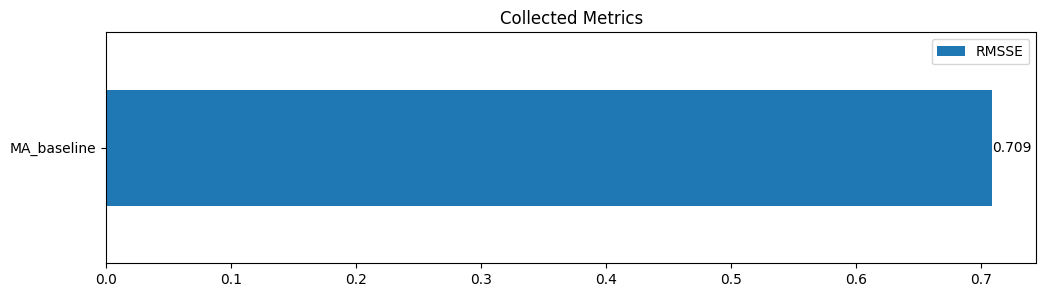

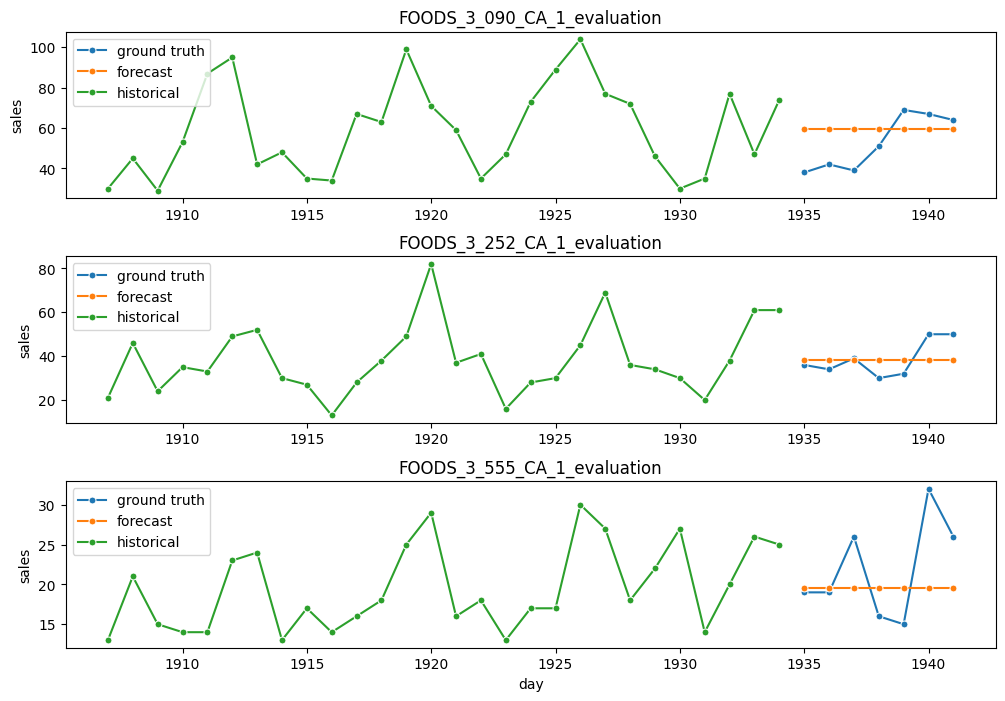

In [ ]:
results = {}
results["MA_baseline"] = round(mean_RMSSE(df_preds_baseline), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_baseline)

As expected, the predictions form a straight line over the forecasting horizon, that goes straight through the middle of the true values. This is a great starting point to put the other methods up against!

# SARIMA

SARIMA is a forecasting method for univariate time series data, and can be understood by dividing it into each of its components:

- **Autoregressive (AR)**: forecast using a linear combination of past values of our target variable. `p` denotes the number of autoregressive terms, or number of lags to be taken into account.
- **Moving Average (MA)**: forecast using a linear combination of past forecast errors. `q` denotes the number of moving average terms.
- **Integrated (I)**: forecast by differencing past values of our target variable to allow for modelling of non-stationary time series. `d` denotes the differencing order to be used.
- **Seasonal (S)**: includes an explicit seasonal component to the model, which consists of terms similar to the ones described above but computed on backshifts of the seasonal period. `P`, `D` and `Q` denote the `p`, `d` and `q` of the seasonal component, and `s` the seasonal length in the data.

For this experiment, we chose the following parameter values:
- `p`, `q`, `P` and `Q` = `1`, since it yields the simplest form of the model, and higher values didn't significantly improve performance and made the model slower to fit.
- `d` and `D` = `1`, since in our analysis we noticed a linear trend in the data, and the first order difference should be enough to allow our model to capture it.
- `s` = `7`, since our data's strongest seasonal cycle is the weekly one.

It is worth noting that **searching for the correct values for these hyperparameters is generally done manually via several trials and analysis of (partial) autocorrelation plots**, which is off scope for this codecamp. Another option is to use a package such as [autoarima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) to automatically find the set of parameters that best fits the data.

SARIMA shines in its simplicity and interpretability, but can quickly become very slow to fit if the values of `p` and `q` are high.

SARIMA also cannot benefit from cross-learning from several series, which we'll explain below, and unlike its cousin SARIMA-X, fails to be able to incorporate exogenous data as explanatory variables.

<font color="red"> Note: Run cells before expanding them.

In [ ]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7

df_preds_sarima = pd.DataFrame(
    {
        ID: np.repeat(ids_subset, config["num_horizons"]),
        DAY: sales_test[DAY].unique().tolist() * len(ids_subset),
        PRED: [None] * len(ids_subset) * config["num_horizons"]
    },
).set_index(ID)

for id_ in tqdm(ids_subset):
    # select training time series
    train_ts = (
        sales_train[sales_train[ID] == id_][SALES].to_numpy()
    )
    # instance SARIMA model
    model = ARIMA(
        endog=train_ts,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s)
    )
    # fit model
    model = model.fit()

    # predict
    pred = model.forecast(steps=config["num_horizons"])

    # store predictions
    df_preds_sarima.loc[id_, PRED] = pred

df_preds_sarima = df_preds_sarima.reset_index()

  8%|▊         | 2/25 [00:20<03:54, 10.18s/it]


KeyboardInterrupt: ignored

In [ ]:
df_preds_sarima

In [ ]:
results["SARIMA"] = round(mean_RMSSE(df_preds_sarima), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_sarima)

# Forecasting using a tabular ML algorithm: Decision Forests

## Introduction

In the previous section, we used a statistical model to forecast the future sales from the past ones. Although such models can work well in practice, their **power of expression is limited**: notably, SARIMA applies on a single time series, and the relation between the input features and the label is linear.

In this section, we will learn to use a more powerful method by **converting the time series into a single tabular dataset** and using an **off-the-shelf** machine learning algorithm to forecast.

<font color="red"> Note: Collapse this section and run cells before continuing.


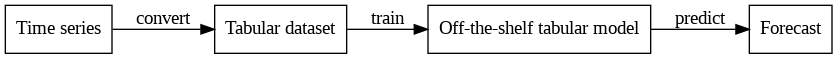

In [ ]:
#@title

import pydot
from IPython.display import Image

dot_string = """graph {
rankdir="LR";
node [shape="box"];
edge [dir=forward];

a -> b [label="convert"];
b -> c [label="train"];
c -> d [label="predict"];

a [label="Time series"];
b [label="Tabular dataset"];
c [label="Off-the-shelf tabular model"];
d [label="Forecast"];
}"""

graphs = pydot.graph_from_dot_data(dot_string)
graphs[0].write_png("output.png")
Image("output.png")

In this particular example, we will use Gradient Boosted Decision Trees (GBDTs) models as they are easy to use and well suited for tabular datasets.

Unlike SARIMA, we will be training a single model for all the existing IDs, instead of one for each, since GBDTs benefit from large datasets, and training a single one also allows for cross-learning, which means the model being able to learn and use patterns from multiple time series at the same time.

We won't explain how Gradient Boosted Trees work here. If you want to learn more about GBDTs and other decision forest models, [Google's Decision Forests class](https://developers.google.com/machine-learning/decision-forests) is a good resource.

The techniques we show in this section can also be used with any other ML model for tabular data. For example, one can use a random forest, an SVM, a nearest neighbors model, or a feed-forward neural network.

## Minimal GBDT crash course

In the context of temporal modeling, there are some things to know about GBDTs:

1. GBDTs are a collection of small decision trees. The prediction of the model is the sum of the predictions of the individual trees. The way GBDTs are trained makes that the first trees are the most important for the predictions.

2. GBDTs work well with default settings. Hyper-parameter tuning can improve the model quality, but will not be covered in this tutorial.

3. GBDTs can natively consume numerical and categorical features. It is *not* a good idea to use one-hot encoding for categorical features in GBDTs.

4. GBDTs are **not able to extrapolate** values, that is, the model is only able to predict within the range of already seen values. For example, if the labels of the training examples are between 0 and 100, the GBDT is unlikely to make predictions outside of this range. If we suspect our dataset needs extrapolation patterns and we want to use a GBDT, we would need to pre-process our labels (e.g. using an STL model first). Note that such label pre-processing can also be beneficial even if the model does not need to extrapolate. We will not cover extrapolation in this tutorial.

## Features

We want to manually create tabular features that correspond to the temporal patterns we think are discriminant for our data. In this section, we will start with a simple option: feeding each series' last 28 values to the model.

In the next sections, we show more advanced feature engineering and how to feed other signals into the model.

## Labels

Our objective is to forecast the sales for the next 7 days. There are two common solutions to make such labels:

1. With **direct method**, we train a separate model for each of the 7 days. For example, the first model predicts the next day's sales, the second model predicts the sales two days in the future, and the last model predicts the sales 7 days from now.

2. With the **recursive method**, we train a single model to predict the next day's sales. This model is applied iteratively using its predictions as input features for its next prediction.

<img src="https://drive.google.com/uc?export=view&id=1A7sdEKc1BTPD1mPQHt3SRVWTUCIJJtm2" height=400/>

In this tutorial, we focus on the direct method. Know that both methods are valid, and the one that will work best depends on the dataset.

*Trivia*: The method that won the M5 competitions was composed of an ensemble of direct and recursive GBDTs.


**Question:** What are three fundamental differences between the recursive and direct method.





In [ ]:
#@title Solution

# 1. Training a separate model for each horizon for the direct approach takes longer than training a single model for the recursive approach.
# 2. In the recursive approach, the model needs to be applied multiple times in sequence, while in the direct approach, models can be applied in parallel.
# 3. In the recursive approach, the error made at one step propagates and is possible piles-up in the next steps.
# 4. In the direct approach, the predictions for different horizons are generated independently and are possibly not correlated.



## Labels: The next h days of sales

The label with horizon $h$ at time $t$ is the sales value at time $t+h$. In other words, the label *shifts* the data from the future to the past.

In [ ]:
def create_labels(
    ds: pd.DataFrame,
    predict_horizon: int=config["num_horizons"]
) -> pd.DataFrame:
  """Extract tabular labels for the next `predict_horizon` steps.

  Returns a dataframe with the extracted label, the label keys, and the
  horizons.
  """

  ds = ds.copy()
  grouped_sales = ds.groupby([STORE, ITEM])[SALES]
  keys = []
  horizons = list(range(1, predict_horizon + 1))

  for h in horizons:
    key = f"label_h_{h}"
    ds[key] = grouped_sales.transform(lambda item: item.shift(-h))
    keys.append(key)

  return ds, keys, horizons

Lets visualize this shift:

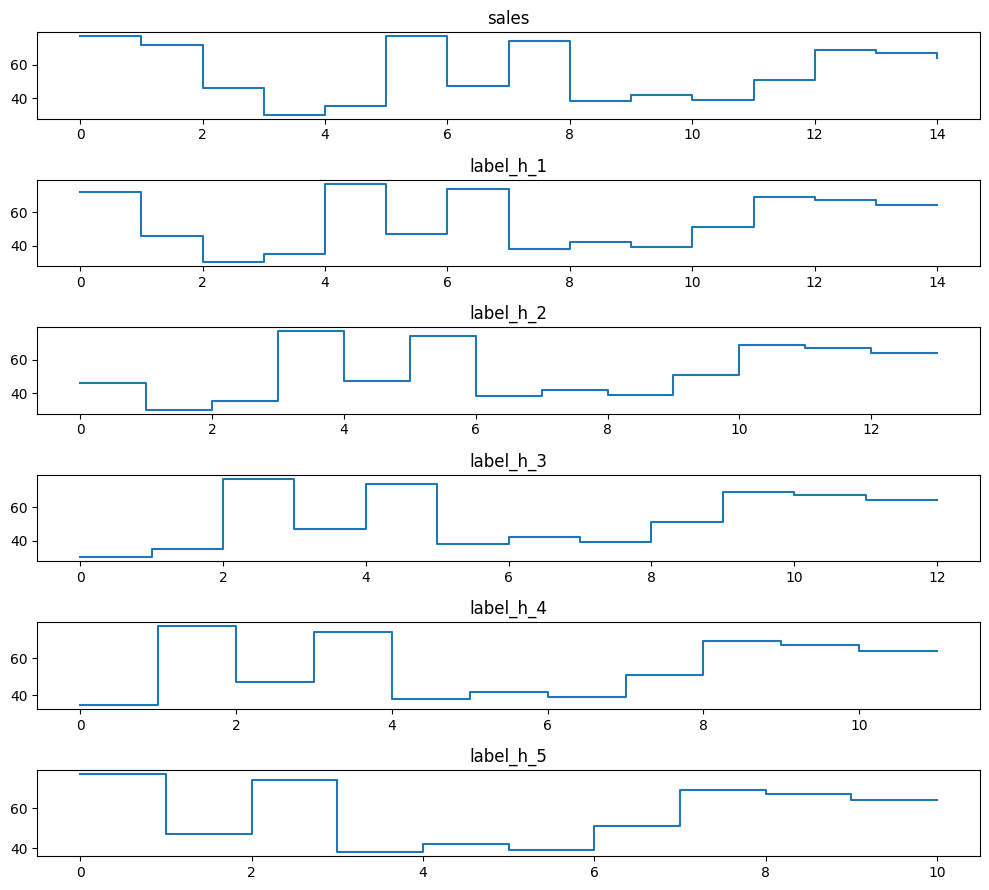

In [ ]:
def plot_tabular_features(dataset: pd.DataFrame, column_names:List[str], num_steps:int=28, subfig_height:float=1.5):
  """Plot tabular features / labels."""

  # Select only the selected item+store
  dataset = dataset[dataset[ID] == example_id]

  # Select the last "num_steps" days.
  if num_steps is not None:
    dataset = dataset[dataset.d >= last_day - num_steps]

  fig, axes = plt.subplots(nrows=len(column_names), ncols=1, figsize=(10,subfig_height*len(column_names)))
  for column_idx, column_name in enumerate(column_names):
    values = dataset[column_name]
    axes[column_idx].step(list(range(len(values))),values, where="post")
    axes[column_idx].set_title(column_name)
  fig.tight_layout()
  fig.show()

# Generate the labels
dataset, label_keys, _ = create_labels(sales, predict_horizon=5)

# Plot the labels
plot_tabular_features(dataset, [SALES] + label_keys, num_steps=14)

**Question:** Can you see the "shift" of the label when h increases? What would a shift in the other direction mean?

## Features: The last 28 days of sales

Computing the last 28 days of sales is similar to computing the labels, except that the shift is in the opposite direction.

In [ ]:
def create_feature_lag_sales(
    ds: pd.DataFrame,
    num_steps: int=28
) -> pd.DataFrame:
  """Extract the last `num_steps` sales as tabular features.

  Returns the updated dataframe and the feature keys.

  Increasing the value of num_steps could increase the quality of the results,
  but also increase the training time.
  """

  ds = ds.copy()
  grouped_sales = ds.groupby([STORE, ITEM])[SALES]
  keys = []

  for h in range(0, num_steps):
    key = f"lag_{h}.sales"
    # TODO: add you code here #
    keys.append(key)

  return ds, keys

In [ ]:
#@title Solution
def create_feature_lag_sales(
    ds: pd.DataFrame,
    num_steps: int=28
) -> pd.DataFrame:
  """Extract the last `num_steps` sales as tabular features.

  Returns the updated dataframe and the feature keys.

  Increasing the value of num_steps could increase the quality of the results,
  but also increase the training time.
  """

  ds = ds.copy()
  grouped_sales = ds.groupby([STORE, ITEM])[SALES]
  keys = []

  for h in range(0, num_steps):
    key = f"lag_{h}.sales"
    ds[key] = grouped_sales.transform(lambda item: item.shift(h))
    keys.append(key)

  return ds, keys

## Assemble the tabular datasets

*Remember: Days 1-1913 are used for the training dataset, days 1914-1941 are used for the testing dataset.*

The number of tabular training examples is different for each horizon.

**Details:** For example, day 1913 (the last day in the training dataset) is the label for the training tabular example with horizon 1 on day 1912. But day 1913 is also the label for the training tabular example with horizon 2 on day 1911, etc.
However, there is no training dataset for model training with horizion 2 on day 1913 (since this would require it to use the values of day 1914 which is not part of the training dataset).


For similar reasons, lagging features are not available for the steps of the training dataset. For instance, lagging of 3 is not available on days 1-3.


The following functions `get_tab_test_dataset` and `get_tab_train_dataset` extract valid training and testing tabular datasets.


In [ ]:
# Split the dataset into training and testing
def get_tab_test_dataset(dataset_with_labels: pd.DataFrame):
  """Build the testing dataset."""

  # The test only contain one row for each example. This row correspond to the
  # last day of training (day=1913), and predicts the next 28 days (1914-1941).
  mask = dataset_with_labels[DAY] == train_cutoff_day
  return dataset_with_labels[mask]

def get_tab_train_dataset(
    dataset_with_labels: pd.DataFrame,
    horizon: int,
    skip_days: int=28
) -> pd.DataFrame:
  "Build the training dataset"

  assert horizon > 0

  # We skip the first "skip_days" of training a there are not enough historical
  # data to compute the lags reliably.

  # Make sure we don't use test examples.
  last_day = train_cutoff_day - horizon
  mask = (
      (dataset_with_labels[DAY] >= skip_days) &
      (dataset_with_labels[DAY] <= last_day)
  )
  return dataset_with_labels[mask]

In [ ]:
# Build the label and features.
dataset = sales
dataset, label_keys, label_horizons = create_labels(dataset)
dataset, feature_lag_sales_keys = create_feature_lag_sales(dataset)

# Collect the signals
#
# Note: Later, we will add all the meta data (e.g. stage, store id,
# item category) at input feature to the model.
meta_columns = [STORE, ITEM]
feature_names = feature_lag_sales_keys + meta_columns
dataset = dataset[feature_names + label_keys + [ID, DAY]]

get_tab_test_dataset(dataset).head()

,lag_0.sales,lag_1.sales,lag_2.sales,lag_3.sales,lag_4.sales,lag_5.sales,lag_6.sales,lag_7.sales,lag_8.sales,lag_9.sales,...,item_id,label_h_1,label_h_2,label_h_3,label_h_4,label_h_5,label_h_6,label_h_7,id,d
48325,74,47.0,77.0,35.0,30.0,46.0,72.0,77.0,104.0,89.0,...,FOODS_3_090,38.0,42.0,39.0,51.0,69.0,67.0,64.0,FOODS_3_090_CA_1_evaluation,1934
48326,61,61.0,38.0,20.0,30.0,34.0,36.0,69.0,45.0,30.0,...,FOODS_3_252,36.0,34.0,39.0,30.0,32.0,50.0,50.0,FOODS_3_252_CA_1_evaluation,1934
48327,25,26.0,20.0,14.0,27.0,22.0,18.0,27.0,30.0,17.0,...,FOODS_3_555,19.0,19.0,26.0,16.0,15.0,32.0,26.0,FOODS_3_555_CA_1_evaluation,1934
48328,71,45.0,42.0,44.0,34.0,41.0,48.0,61.0,52.0,43.0,...,FOODS_3_586,34.0,46.0,33.0,18.0,33.0,48.0,43.0,FOODS_3_586_CA_1_evaluation,1934
48329,29,20.0,21.0,12.0,21.0,10.0,23.0,21.0,25.0,14.0,...,FOODS_3_587,40.0,21.0,24.0,29.0,40.0,39.0,52.0,FOODS_3_587_CA_1_evaluation,1934


## Train GBDT

Let's train GBDTs for each of the horizons. We are using the [Tensorflow Decision Forests library](https://www.tensorflow.org/decision_forests/) to train the trees.

**Note:** For the sake of training quickly, the GBDTs will be trained with only a few trees (10 or 50). To get reasonable results, GBDTs should be trained on much more trees (e.g. 500).

**Note:** Make sure to run training cells before diving into the explanation.

In [ ]:
class DirectGBDTResult(NamedTuple):
  """Result of the "train_direct_gbt_models" function."""

  # Number of trees
  num_trees: int

  # Features the model was trained on
  feature_names: List[str]

  # Models for each horizon
  models: List[tfdf.keras.GradientBoostedTreesModel]

  # RMSE of the model for each horizon computed on the validation data
  self_evaluation: List[float]

  # Dictionary mapping time series ids to next-horizon forecasts
  predictions: Dict[str, np.array]

In [ ]:
def train_direct_gbt_models(
    dataset: pd.DataFrame,
    feature_names: List[str],
    num_trees: int=config["num_trees"],
    num_horizons: int=config["num_horizons"],
    verbose: int=0,
) -> DirectGBDTResult:
  """Trains a GB(D)T model for each of the horizons.

  Args:
    dataset: Tabular dataset containing training and test examples..
    feature_names: Input features of the model.

  Returns:
    The predictions for each item and each horizon, the models, and the
    self-model evaluation.
  """
  # Extract the test dataset
  #
  # Note: The test dataset contains a single day.
  test_tab_ds = get_tab_test_dataset(dataset)

  # Predictions of each model on each ID.
  predictions = []

  # Model self evaluation (RMSE) for each of the horizons.
  self_evaluation = []

  # The GBT models.
  models = []

  for horizon in range(1, num_horizons + 1):

    # Extract the train dataset for this horizon
    train_tab_ds = get_tab_train_dataset(dataset, horizon=horizon)

    # Convert dataset from Pandas to TensorFlow format
    label_key = f"label_h_{horizon}"
    train_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_tab_ds,
        label=label_key,
        task=tfdf.keras.Task.REGRESSION
    )
    test_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_tab_ds,
        label=label_key,
        task=tfdf.keras.Task.REGRESSION
    )

    # Train a GBT
    print(
        f"Training model for horizon={horizon} |"
        f" {len(train_tab_ds)} training examples |"
        f" {len(test_tab_ds)} test examples"
    )
    model = tfdf.keras.GradientBoostedTreesModel(
        # Only use those features.
        features=[tfdf.keras.FeatureUsage(feat) for feat in feature_names],
        exclude_non_specified_features=True,
        num_trees=num_trees,
        # This is a regression task.
        task=tfdf.keras.Task.REGRESSION,
        # Control the amount of training logs.
        verbose=verbose,
    )
    model.fit(train_ds_tf)
    models.append(model)

    # Extract the model self-evaluation. In this case, the self evaluation if
    # the validatin RMSE.
    self_evaluation.append(model.make_inspector().evaluation().rmse)

    # Generate prediction on test dataset.
    predictions.append(model.predict(test_ds_tf, verbose=0).flatten())

  # Format predictions to be compatible with the "plot_predictions" function.
  stacked_predictions = {
      test_tab_ds.iloc[i][ID]: predictions
      for i, predictions in enumerate(np.array(predictions).T)
  }
  return DirectGBDTResult(
      num_trees=num_trees,
      feature_names=feature_names,
      predictions=stacked_predictions,
      self_evaluation=self_evaluation,
      models=models,
  )

In [ ]:
%%time
gbdt_result = train_direct_gbt_models(
    dataset=dataset,
    feature_names=feature_names,
)

Training model for horizon=1 | 47650 training examples | 25 test examples


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Training model for horizon=2 | 47625 training examples | 25 test examples
Training model for horizon=3 | 47600 training examples | 25 test examples


Training model for horizon=4 | 47575 training examples | 25 test examples
Training model for horizon=5 | 47550 training examples | 25 test examples


Training model for horizon=6 | 47525 training examples | 25 test examples


Training model for horizon=7 | 47500 training examples | 25 test examples
CPU times: user 4min 24s, sys: 4.71 s, total: 4min 29s
Wall time: 3min 29s


## Model self-evaluation

In the cell above, we did not provide a validation dataset. Therefore, the model automatically extracted 10% of the training dataset for validation. The next plots show

1. The validation RMSE of the 7 models according to their forecast horizon, and
2. The validation RMSE according to the number of trees for the h=7 model.

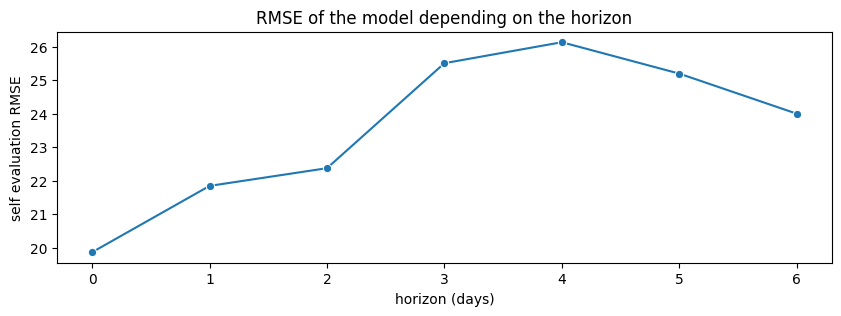

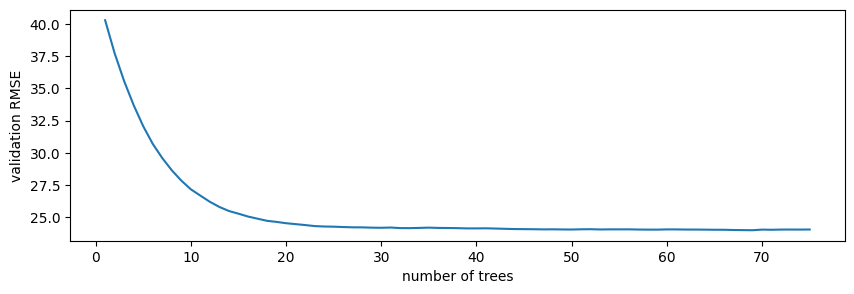

In [ ]:
#@title
def plot_self_evaluation(
    gbdt_result: DirectGBDTResult,
    figsize: Tuple[int, int]=(10, 3)
) -> None:
    """Plot RMSE of the model on the validation dataset according to the horizon."""

    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(
        data=gbdt_result.self_evaluation,
        marker="o",
        ax=ax
    )
    ax.set_xlabel("horizon (days)")
    ax.set_ylabel("self evaluation RMSE")
    ax.set_title("RMSE of the model depending on the horizon")

def plot_learning_curve(
    gbdt_result: DirectGBDTResult,
    figsize: Tuple[int, int]=(10, 3)
) -> None:
    """Plot RMSE of the modle on the validation according to the number of trees."""

    logs = gbdt_result.models[-1].make_inspector().training_logs()
    fig, ax = plt.subplots(figsize=figsize)

    sns.lineplot(
        x=[log.num_trees for log in logs],
        y=[log.evaluation.rmse for log in logs],
        ax=ax
    )
    ax.set_xlabel("number of trees")
    ax.set_ylabel("validation RMSE")

plot_self_evaluation(gbdt_result)
plot_learning_curve(gbdt_result)

We see that the the larger the horizon, the harder it is for models to predict the sales, and the worst the model quality gets (RMSE increases). We also notice that learning for this model seems to plateu at around 60 trees.

### Question

1. The validation dataset is randomly sampled from the training dataset. Could you think about another way to extract the validation dataset?
2. What would be the impact?

In [ ]:
#@title Solution

#
# Ideally, the "difference" (or "distance") between the training and validation distribution should be the same as the
# difference between the training and serving (or testing) distribution.
#
# In the solution above, the training and testing datasets are separated in time, however the training and validation
# datasets are not.  This could lead to issues with the models and in many cases you would not want to do that. For
# example, the model would over-fit to the training window and we would not notice it before the evaluation on the
# testing dataset.
#
# A common schema is to split temporarily (i.e. by date) the training, validation and testing dataset.
#
# In this notebook, the validation dataset is only used to create the validation plot above and does not
# impact the model itself.


## Looking at predictions

Let's look at examples of predictions.

In [ ]:
#@title
def parse_gbdt_predictions(
    gbdt_result: DirectGBDTResult
) -> pd.DataFrame:
    """Re-format the predictions generated by a gradient boosting decision tree
    (GBDT) model into a pandas DataFrame that is compatible with
    `plot_predictions.`

    Args:
    gbdt_result: a DirectGBDTResult object that contains the predictions
    generated by the GBDT model.

    Returns: pandas DataFrame containing the re-formatted predictions, with
    three columns: ID, DAY, and PRED.

    Input Format:
    -------------
    The DirectGBDTResult object should contain a dictionary of predictions,
    where the keys are the IDs of the time series being forecasted, and the
    values are arrays of predicted values for each horizon. The number of
    horizons must be the same for all time series. The format of the dictionary
    should be as follows:
    {
    ID_1: [pred1_horizon_1, pred_1_horizon_2, ..., pred_1_horizon_N],
    ID_2: [pred2_horizon_1, pred_2_horizon_2, ..., pred_2_horizon_N],
    ...
    ID_n: [pred_n_horizon1, pred_n_horizon2, ..., pred_n_horizon_N]
    }

    The values of the "ID" keys should be unique identifiers for the time series
    being forecasted, and the "pred" values should be arrays of predicted values
    for each horizon. The length of each "pred" array should be the same,
    and equal to the number of horizons being predicted.
    """

    # number of predicted horizons
    n_horizons = len(next(iter(gbdt_result.predictions.values())))
    ids = list(gbdt_result.predictions.keys())

    # parse results into DataFrame
    df_preds_gbdt = pd.DataFrame(
        {
            ID: np.repeat(ids, n_horizons),
            DAY: list(
                range(train_cutoff_day + 1, train_cutoff_day + n_horizons + 1)
            ) * len(ids),
            PRED: np.array(list(gbdt_result.predictions.values())).flatten()
        },
    )
    return df_preds_gbdt

df_preds_gbdt = parse_gbdt_predictions(gbdt_result)
df_preds_gbdt.head()

,id,d,sales_pred
0,FOODS_3_090_CA_1_evaluation,1935,58.754807
1,FOODS_3_090_CA_1_evaluation,1936,46.701157
2,FOODS_3_090_CA_1_evaluation,1937,41.596416
3,FOODS_3_090_CA_1_evaluation,1938,55.822384
4,FOODS_3_090_CA_1_evaluation,1939,71.556709


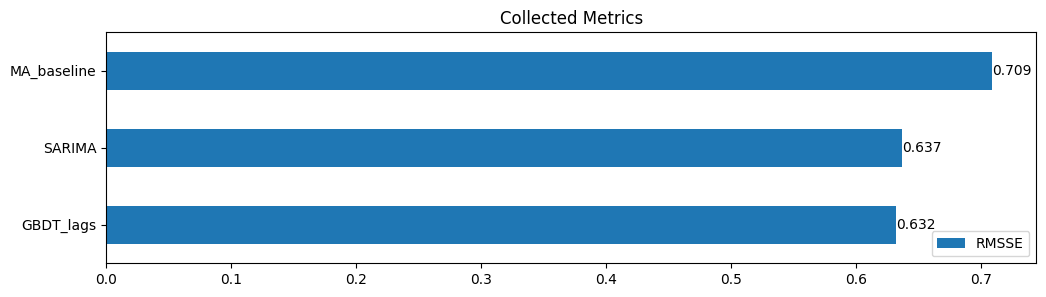

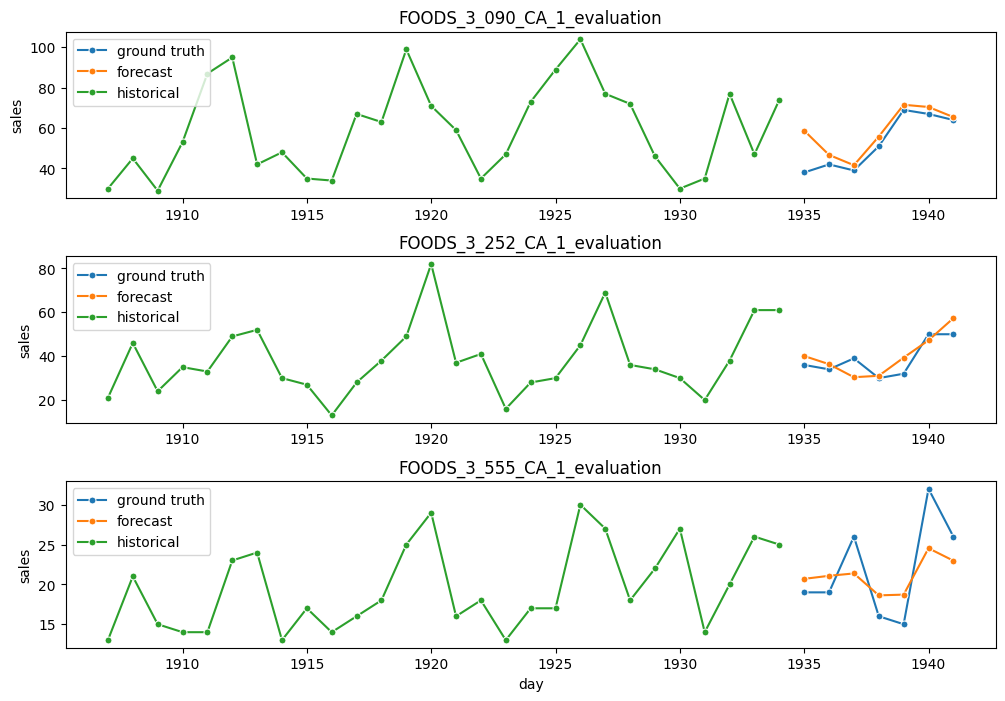

In [ ]:
results["GBDT_lags"] = round(mean_RMSSE(df_preds_gbdt), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_gbdt)

# Feature engineering for time series

<img width=50% align="right" src="https://pbs.twimg.com/media/FiWW_5gX0AcnFQz?format=jpg&name=4096x4096"/>

As mentioned before, one of the stronger arguments for choosing a general purpose model over SARIMA for this task is their ability to consume several **new streams of information as part of their input signal**, instead of being restricted to learning from series' past values only.

These new streams, referred to as **exogenous data**, can be thought of as independent or explanatory variables, that might be able to explain the behavior of our dependent variable, the sales values. As an example, in our specific case, data such as an item's selling price, general macroeconomic data, closeness in time to special calendar events and aggregated information about its store or category's past behavior can all play a role in explaining current sales values.

In this next section, we'll iterate over computing new features, and feeding them to a new model to compare results.

## Calendar features

We've already successfully given our model rich information about each item's past behavior. However, its still missing a key piece of data: at what date each sale occurs! Without knowing the year, month, or day of the week it is supposed to be predicting for, it will be hard for it to robustly learn the seasonal patterns that are present in our dataset.

We can transform the day, weekday, week, month and year of a specific date to a numerical feature very easily just by linearly encoding it as an integer: the first day of the week is a `0` and the last is a `6`, and same for all other ones.

Note that, even though this will be enough for our tree-based models, it makes it very hard for a linear model, or even a neural net, to associate that monday (`0`), is much closer to sunday (`6`) than it is to thursday (`3`)! Same goes for december and january, and the last and first day of each month.

If feeding **cyclical features** like these to a linear model, a common method is to transform the data into two dimensions using sine and cosine transformations, making values at the start and end of the range take similar values in both new dimensions. [This kaggle post](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning) does a good job of explaning the method.

<font color="red"> Note: Collapse this section and run cells before continuing.

### Merge calendar data

The `calendar.csv` contains information about the days in our dataset, that might be explanatory of sales behavior.

For each `"d"`, it specifies the weekday, month and year it corresponds to, any special events that occurred on that date (such as Christmas or Mother's day), and three extra variables indicating whether a special discount called SNAP was available in each of the three states we have data in.

Let's load it and merge it with our sales data.

In [ ]:
# load calendar data
calendar = pd.read_csv(
    "calendar.csv",
    parse_dates=[DATE],
)
# Convert d column to int to be able to operate on it.
calendar[DAY] = calendar[DAY].str[2:].astype(np.int32)

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
# merge calendar info with sales data
sales = sales.merge(
    calendar[[DAY, DATE]],
    on=DAY,
    how="left",
)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date
0,FOODS_3_090_CA_1_evaluation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1,107,2011-01-29
1,FOODS_3_252_CA_1_evaluation,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,1,19,2011-01-29
2,FOODS_3_555_CA_1_evaluation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,1,23,2011-01-29
3,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,1,42,2011-01-29
4,FOODS_3_587_CA_1_evaluation,FOODS_3_587,FOODS_3,FOODS,CA_1,CA,1,50,2011-01-29


In [ ]:
# create linear date features (since its simpler) and retrain model with them
def create_features_date(
    dataset: pd.DataFrame,
    include_cyclical: bool = False
) -> Tuple[pd.DataFrame, List[str]]:
    """Encode the date into several feature columns with the day, day of
    the week, week, month and year, in both linear and cyclical representations.

    Params:
        dataset: the dataset with the "date" column to be encoded.
        include_cyclical: whether to include cyclical encoding of features.
            If False, only linear encoding is returned.

    Returns:
        tuple containing the dataset with the new features and the names of the
        columns with the new features.
    """
    # linear encoding
    dt = dataset[DATE].dt

    features = pd.DataFrame(
        {
            "year": dt.year,
            "month_of_year": dt.month,
            #"week_of_year": dt.isocalendar().week.astype(int),
            #"day_of_year": dt.dayofyear,
            "day_of_month": dt.day,
            "day_of_week": dt.weekday,
        }
    )

    # cyclical encoding
    if include_cyclical:
        cyclical_week_of_year = (features["week_of_year"] - 1) * (2 * np.pi / 52)
        cyclical_month_of_year = (features["month_of_year"] - 1) * (2 * np.pi / 12)

        cyclical_day_of_month = (features["day_of_month"] - 1) * (2 * np.pi / 31)
        cyclical_day_of_week = features["day_of_week"] * (2 * np.pi / 7)

        features = features.assign(
            **{
                "week_n_sin": np.sin(cyclical_week_of_year),
                "week_n_cos": np.cos(cyclical_week_of_year),
                "dayofmonth_sin": np.sin(cyclical_day_of_month),
                "dayofmonth_cos": np.cos(cyclical_day_of_month),
                "dayofweek_sin": np.sin(cyclical_day_of_week),
                "dayofweek_cos": np.cos(cyclical_day_of_week),
                # Redundant with week_n but with less granularity, pick one
                # "month_sin": np.sin(cyclical_month_of_year),
                # "month_cos": np.cos(cyclical_month_of_year),
            }
        )

    result = pd.concat([dataset, features], axis=1)

    return result, features.columns.tolist()

Let's look at the generated features:

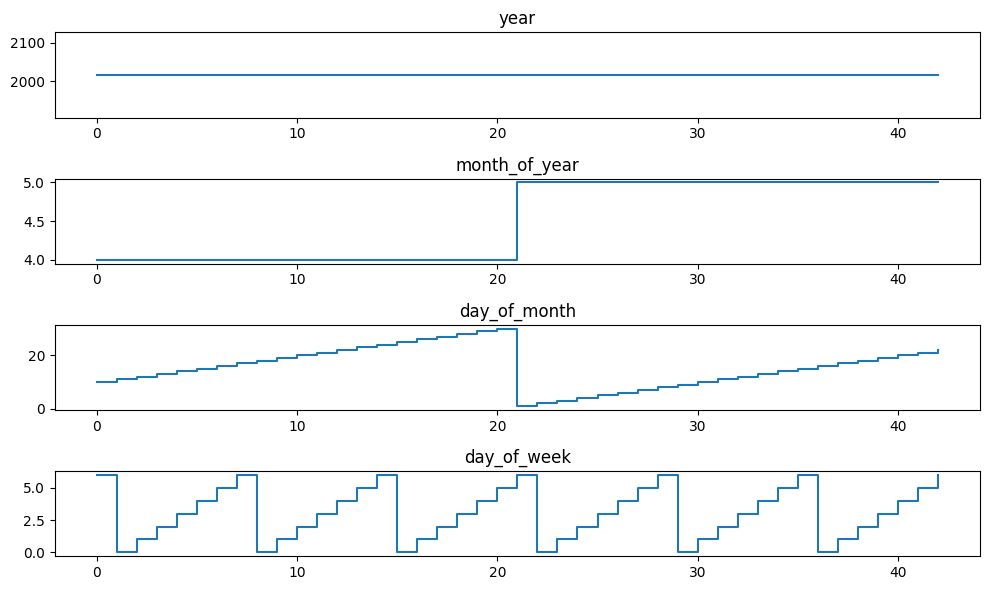

In [ ]:
# Generate the labels
feature_values, feature_names = create_features_date(sales)

# Plot the labels
plot_tabular_features(feature_values, feature_names, num_steps=7 * 6) # 6 weeks

Now, we can re-train our model with those features:

In [ ]:
# Build the label and features.
dataset = sales
dataset, label_keys, label_horizons = create_labels(dataset)
dataset, feature_lag_sales_keys = create_feature_lag_sales(dataset)
dataset, feature_date_keys = create_features_date(dataset)

feature_names = feature_lag_sales_keys + feature_date_keys + meta_columns
dataset = dataset[feature_names + label_keys + [ID, DAY]]

In [ ]:
%%time
gbdt_result_cal = train_direct_gbt_models(
    dataset=dataset,
    feature_names=feature_names,
)

Training model for horizon=1 | 47650 training examples | 25 test examples
Training model for horizon=2 | 47625 training examples | 25 test examples
Training model for horizon=3 | 47600 training examples | 25 test examples
Training model for horizon=4 | 47575 training examples | 25 test examples
Training model for horizon=5 | 47550 training examples | 25 test examples
Training model for horizon=6 | 47525 training examples | 25 test examples
Training model for horizon=7 | 47500 training examples | 25 test examples
CPU times: user 4min 56s, sys: 5.55 s, total: 5min 1s
Wall time: 4min 27s


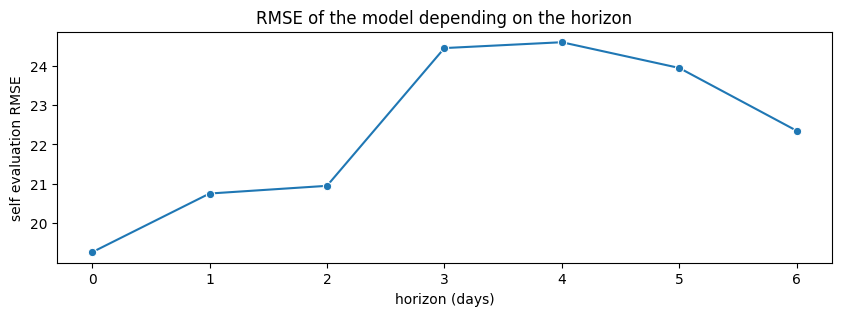

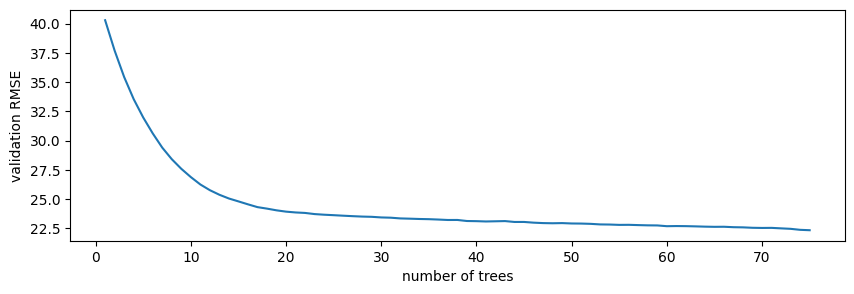

In [ ]:
plot_self_evaluation(gbdt_result_cal)
plot_learning_curve(gbdt_result_cal)

In [ ]:
df_preds_gbdt_cal = parse_gbdt_predictions(gbdt_result_cal)
df_preds_gbdt_cal.head()

,id,d,sales_pred
0,FOODS_3_090_CA_1_evaluation,1935,49.840286
1,FOODS_3_090_CA_1_evaluation,1936,42.969997
2,FOODS_3_090_CA_1_evaluation,1937,41.141678
3,FOODS_3_090_CA_1_evaluation,1938,53.176361
4,FOODS_3_090_CA_1_evaluation,1939,63.739010


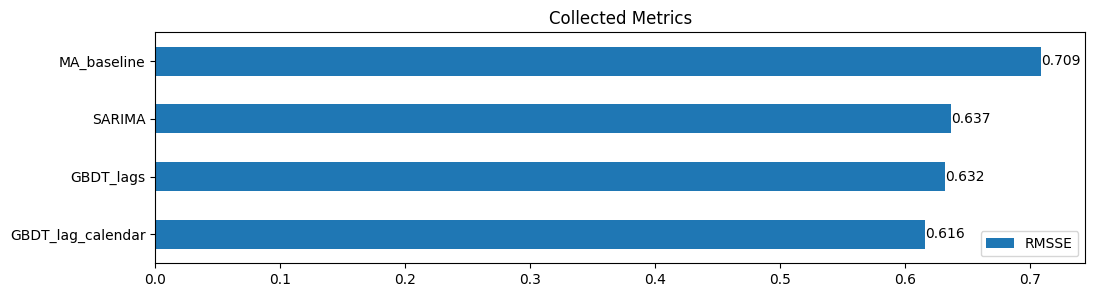

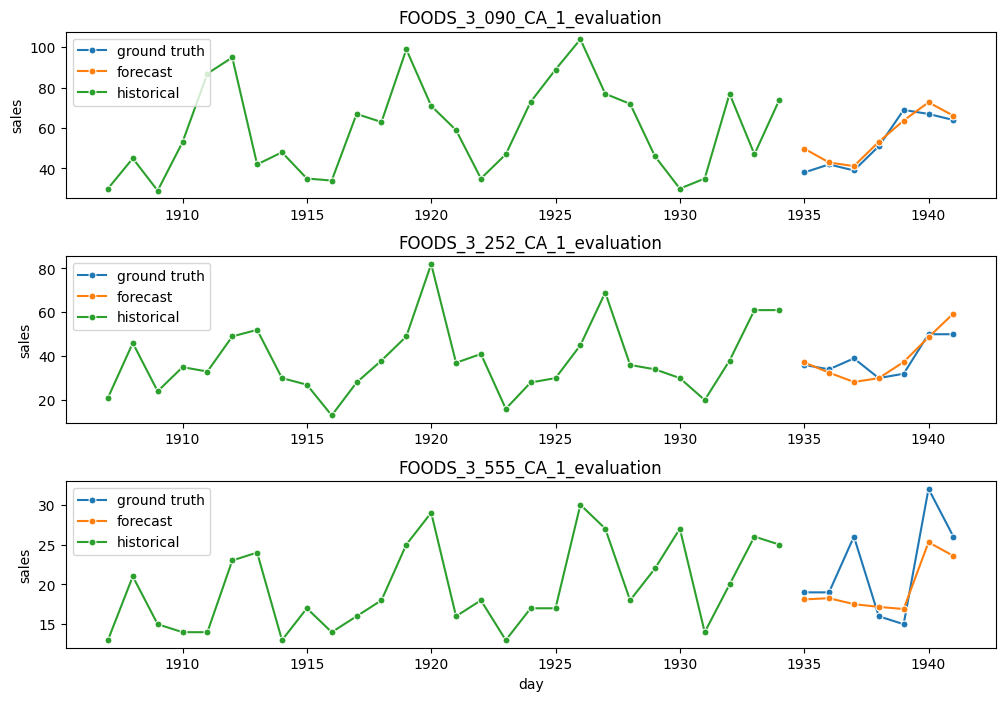

In [ ]:
results["GBDT_lag_calendar"] = round(mean_RMSSE(df_preds_gbdt_cal), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_gbdt_cal)

## Moving statistics

<img src="https://lh3.google.com/u/0/d/1M4RLdq_xLC9nq-S0Qp481PYq96RBHfGy=w3840-h1888-iv1"/>

In the first iteration of the GBDT model, we used lagged sales only as the model's input features.

Another useful family of features are  moving statistics. These features are computed by appliying a statistical aggregation function (e.g. mean, standard deviation, max) over a window that "rolls" across the input time series. Mathematically:

$$
f[n] = F(\{ s[n - w] \ | \ w \in [0, W - 1] \})
$$

Where $f[n]$ is the value of the moving statistic computed on time series $s$ at time $n$, $F : \mathbb{R}^{W} \rightarrow \mathbb{R}$ is the statistical aggregation function, and $W \in \mathbb{N}$ is the window length. Note that the result of this process is also a time series.

In this codecamp, we'll be using moving statistics as input features to train a GBDT model. However, they can also help us identify global trends in the data (moving average) or periods of high or low volatility (moving standard deviation), or anomalies (moving peak detection). As such, they enable scientists to gain deeper insights into the complex dynamics of time-dependent data while also supporting the development of powerful forecasting models.

Examples of moving statistics include:

- <b>Simple Moving Average:</b> This is the most commonly used moving statistic. It calculates the average of the values in the rolling window.

- <b>Moving Standard Deviation:</b> This calculates the standard deviation of the values in the rolling window. It can help to identify periods of high or low volatility in the data.

- <b>Moving Median:</b> This calculates the median of the values in the rolling window. It is a robust statistic that is less sensitive to outliers compared to the mean.

- <b>Moving Maximum</b> and <b>Moving Minimum:</b> These calculate the maximum and minimum values in the rolling window, respectively.

We'll take a closer look at these moving statistics in the following cells.

<font color="red"> Note: Collapse this section and run cells before continuing.

The most suitable parameters (window length, aggregation function, etc.) for calculating moving statistics features are unknown. Therefore, we will generate many such features with different parameters, and let the Machine Learning algorithm select the ones with the most predictive power.

In [ ]:
def create_feature_moving_stat(
    df: pd.DataFrame,
    window_length: int,
    agg_fns: List[str] = ["mean"],
    level: List[str] = [STORE, ITEM],
    append: bool = True,
) -> pd.DataFrame:
    """Computes moving statistics for a specified window length, aggregation
    function(s) and hierarchy level.
    Args:
        df: input DataFrame.
        window_length: length of the rolling window in days.
        agg_fns: list of aggregation functions to apply to the rolling window.
            Defaults to ["mean"].
        level: list of column names to group by. Defaults to [STORE, ITEM].
        append: flag indicating whether to append the output DataFrame to the
            input DataFrame or return it separately. Defaults to True.

    Returns:
        DataFrame containing the moving statistics and the name of the
        statistics.
    """

    # calculate moving stats
    df_mov_stats = (
        df
        # aggregate daily sales at specified level
        .groupby(level + [DAY])[SALES]
        .sum()
        .reset_index()
        # group by level
        .groupby(level)
        # roll window
        .rolling(window_length, min_periods=1, on=DAY, closed="right")
        # aggregate
        .agg({SALES: agg_fns})
    )
    # rename columns
    column_names = [
        f"{'_'.join(col_pair)}_{window_length}_{'_'.join(level)}"
        for col_pair in df_mov_stats.columns
    ]

    df_mov_stats.columns = column_names
    # merge & return with input DataFrame or return moving stats only
    if append:
        return df.merge(df_mov_stats, on=level + [DAY], how="left"), column_names

    return df_mov_stats, column_names


def create_feature_moving_stat_all(
    dataset: pd.DataFrame,
    operators: List[str]=["mean", "std"],
    window_lengths: List[int]=[7, 14, 28, 56, 112],
    levels: List[List[str]]=[[STORE, ITEM], [STORE], [ITEM]]
) -> Tuple[pd.DataFrame, List[str]]:
    """Computes moving statistics for multiple window lengths,
    aggregation functions, and hierarchy levels, and returns the resulting
    features concatenated with the input DataFrame.

    Args:
        dataset: pandas DataFrame containing the data to be processed.
        operators: list of aggregation functions to apply to the rolling
            window. Defaults to ["mean", "std"].
        window_lengths: list of integers specifying the lengths of the rolling
            windows to be used in days. Defaults to [7, 14, 28, 56, 112].
        levels: list of lists of column names to group by. Each list of column
            names specifies a level of the hierarchy. Defaults to
            [[STORE, ITEM], [STORE], [ITEM]].

    Returns:
        tuple containing:
        - pandas DataFrame with the original data plus the moving statistics
        features.
        - list of strings representing the names of the newly created features.
    """
    keys = []
    for window_length in window_lengths:
        for level in levels:
            dataset, new_features = create_feature_moving_stat(
                dataset,
                window_length=window_length,
                agg_fns=operators,
                level=level
            )
            keys += new_features

    return dataset, keys

In [ ]:
#@title Definition of `plot_moving_stat`
def plot_moving_stat(
    dataset: pd.DataFrame,
    agg_fns: List[str],
    id_: Optional[str]=None,
    num_days: int=28*3,
    level: List[str]=[STORE, ITEM],
    figsize: Tuple[int, int]=(10, 6),
) -> None:
    # sample time series id if it's not provided
    if id_ is None:
        id_ = dataset[ID].sample(1).item()

    # create figure
    fig, axes = plt.subplots(len(agg_fns) + 1, 1, figsize=figsize)

    # plot raw sales
    sns.lineplot(
        data=dataset[dataset[ID] == id_][-num_days:],
        x="d",
        y=SALES,
        ax=axes[0],
    )
    axes[0].set_title("raw")
    axes[0].set_xlabel(None)
    axes[0].set_ylabel(SALES)
    axes[0].grid(True, axis="x")

    # plot features
    for ax, agg_fn in zip(axes[1:], agg_fns):
        # features to plot
        plot_columns = [
            col
            for col in dataset.columns
            if agg_fn in col and col.endswith("_".join(level))
        ]
        for i, col in enumerate(plot_columns, start=1):
            # extract window length
            window_length = int(re.search(r"\d+", col).group())

            # plot
            sns.lineplot(
                data=dataset[dataset[ID] == id_][-num_days:],
                x="d",
                y=col,
                ax=ax,
                label=f"{window_length=}",
                color=f"C{i}"
            )
            # metadata
            ax.set_title(f"moving {agg_fn}")
            ax.set_xlabel(None)
            ax.set_ylabel(SALES)
            ax.grid(True, axis="x")
            ax.legend(fontsize=8)

    axes[-1].set_xlabel("day")
    plt.subplots_adjust(hspace=0.50)

Let's plot some features

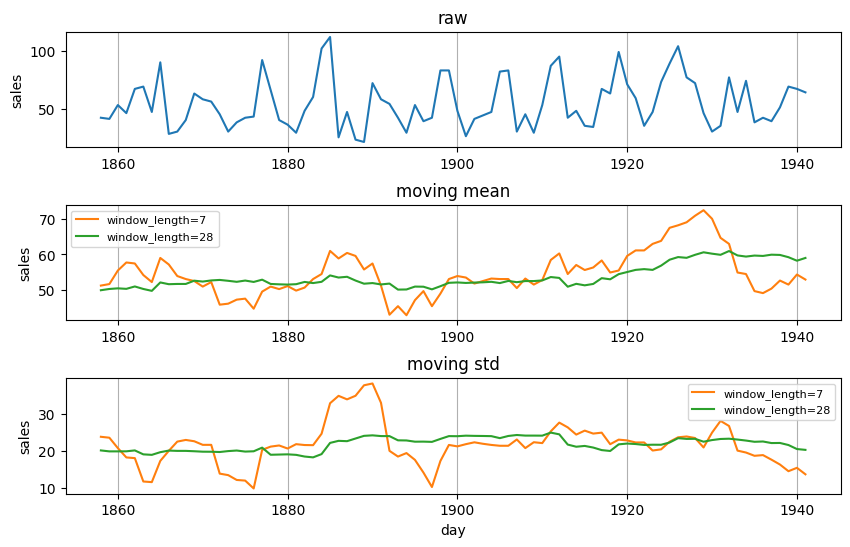

In [ ]:
dataset, feature_moving_stats_keys = create_feature_moving_stat_all(
    sales,
    window_lengths=[7, 28], # 14, 56
    operators=["mean", "std"] # min, max, median
)

# plot resulting moving statistics
plot_id = sales[ID].head(1).item()
plot_moving_stat(
    dataset,
    ["mean", "std"], # min, max, median
    id_=plot_id
)

Since a priori we don't know what are the right parameters, let's generate features with many different parameters.

In [ ]:
# Build the label and features.
dataset = sales
dataset, label_keys, label_horizons = create_labels(dataset)
dataset, feature_lag_sales_keys = create_feature_lag_sales(dataset)
dataset, feature_date_keys = create_features_date(dataset)
dataset, feature_moving_stats_keys = create_feature_moving_stat_all(
    dataset,
    window_lengths=[7, 14, 28, 56],
    operators=["mean", "std"],
    levels=[[STORE, ITEM], [STORE], [ITEM]]
)

# Collect the signals
feature_names = (
    feature_lag_sales_keys +
    feature_date_keys +
    feature_moving_stats_keys +
    meta_columns
)
dataset = dataset[feature_names + label_keys + [DAY, ID]]

In [ ]:
%%time
gbdt_result_mov = train_direct_gbt_models(
    dataset=dataset,
    feature_names=feature_names,
)

Training model for horizon=1 | 47650 training examples | 25 test examples
Training model for horizon=2 | 47625 training examples | 25 test examples
Training model for horizon=3 | 47600 training examples | 25 test examples
Training model for horizon=4 | 47575 training examples | 25 test examples
Training model for horizon=5 | 47550 training examples | 25 test examples
Training model for horizon=6 | 47525 training examples | 25 test examples
Training model for horizon=7 | 47500 training examples | 25 test examples
CPU times: user 9min 42s, sys: 9.37 s, total: 9min 51s
Wall time: 7min 47s


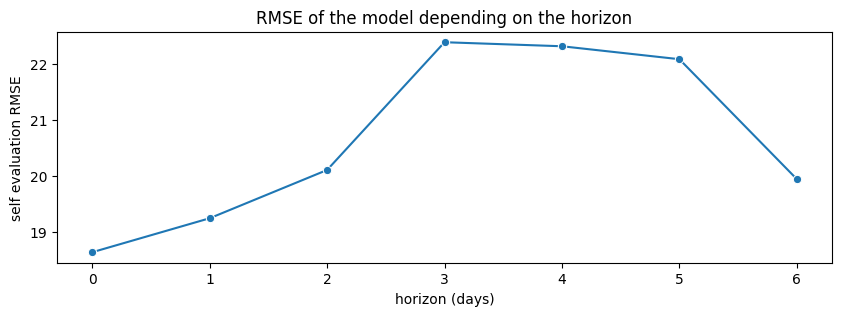

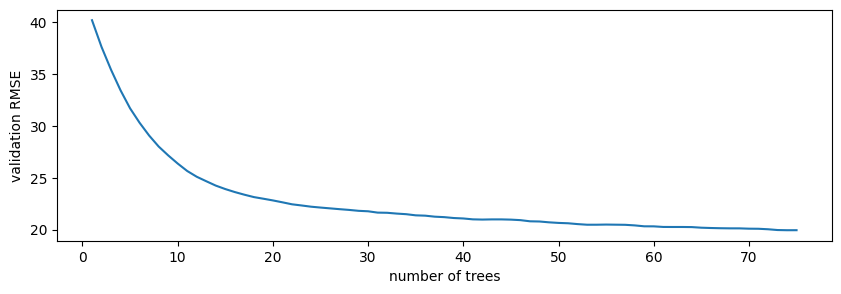

In [ ]:
plot_self_evaluation(gbdt_result_mov)
plot_learning_curve(gbdt_result_mov)

In [ ]:
df_preds_gbdt_mov = parse_gbdt_predictions(gbdt_result_mov)
df_preds_gbdt_mov.head()

,id,d,sales_pred
0,FOODS_3_090_CA_1_evaluation,1935,46.548264
1,FOODS_3_090_CA_1_evaluation,1936,39.965096
2,FOODS_3_090_CA_1_evaluation,1937,40.466812
3,FOODS_3_090_CA_1_evaluation,1938,49.625179
4,FOODS_3_090_CA_1_evaluation,1939,65.695824


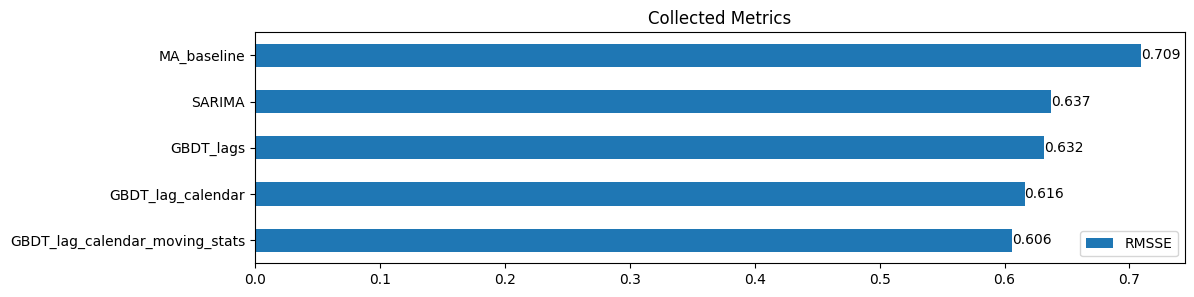

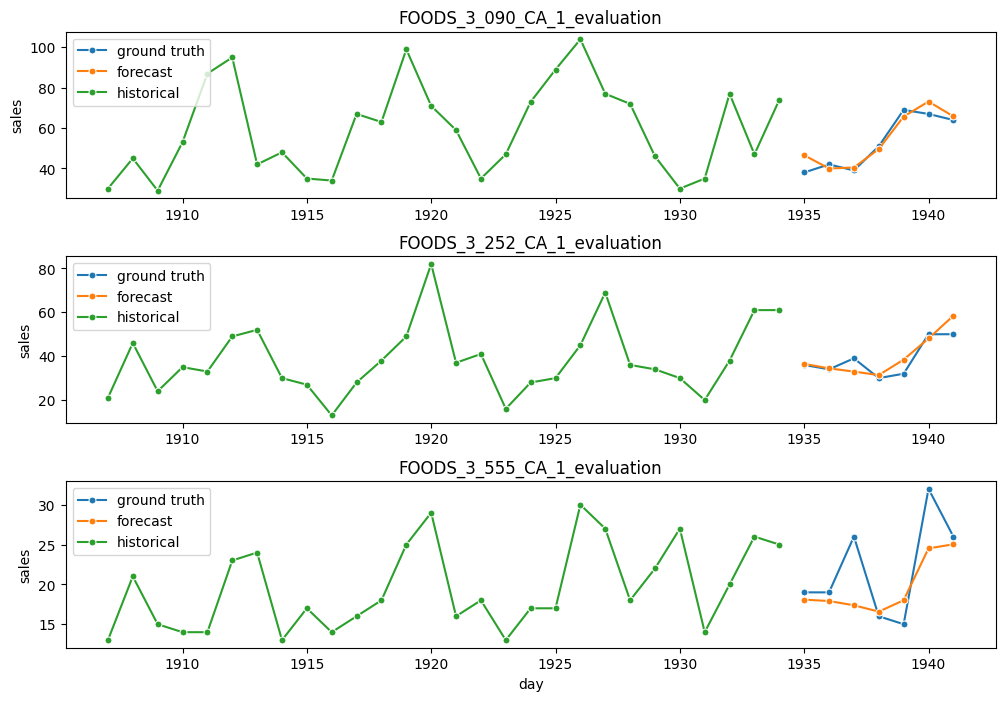

In [ ]:
results["GBDT_lag_calendar_moving_stats"] = round(mean_RMSSE(df_preds_gbdt_mov), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_gbdt_mov)

## Special events

One extra piece of information our model would really appreciate is knowing when some key special events happen in the calendar, and how close each date is to them. This will allow it to model that, for example, a lot of toys are sold during the week before christmas, or a lot of beer is sold during the Superbowl!

To encode this information into our model we can simply generate one feature per each specific event, that encodes the number of days remaining until the next occurence of that event (since in most cases these events repeat on an yearly basis). To do this, lets take a look at the `calendar` data we loaded in the beginning of this notebook.

<font color="red"> Note: Collapse this section and run cells before continuing.

In [ ]:
calendar[calendar["event_type_1"].notna()].tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1926,2016-05-08,11615,Sunday,2,5,2016,1927,Mother's day,Cultural,NaN,NaN,1,0,1
1948,2016-05-30,11618,Monday,3,5,2016,1949,MemorialDay,National,NaN,NaN,0,0,0
1951,2016-06-02,11618,Thursday,6,6,2016,1952,NBAFinalsStart,Sporting,NaN,NaN,1,0,1
1956,2016-06-07,11619,Tuesday,4,6,2016,1957,Ramadan starts,Religious,NaN,NaN,1,1,0
1968,2016-06-19,11621,Sunday,2,6,2016,1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [ ]:
def create_features_events(
    dataset: pd.DataFrame,
    calendar: pd.DataFrame,
) -> Tuple[pd. DataFrame, List[str]]:
    """Create features representing the days remaining until each of the unique
    events present in the "event_name_1" and "event_name_2" columns of `calendar`.

    Params:
        dataset: the dataset with the DAY column to be used.
        calendar: dataframe containing the special events.

    Returns:
        tuple containing the dataset with the new features and the names of the
        columns with the new features.
    """
    calendar_notna = calendar[
        calendar["event_name_1"].notna() |
        calendar["event_name_2"].notna()
    ]
    # calendar_notna[DAY] = calendar_notna[DAY].str[2:].astype(np.uint16)

    days_per_event = defaultdict(list)

    for idx, row in calendar_notna.iterrows():
      for col in ["event_name_1", "event_name_2"]:
        event = row[col]
        if not pd.isna(event):
          event = event.replace(" ", "")
          days_per_event[event].append(row[DAY])

    print(f"{days_per_event=}")
    days_per_event_np = {
        name: np.asarray(days) for name, days in days_per_event.items()
    }

    def days_until_next_in_future(date: int, days: np.ndarray):
      diffs = days - date
      diffs = diffs[diffs > 0]
      if len(diffs) == 0:
        return np.nan
      return diffs.min()

    features = pd.DataFrame(index=dataset.index)
    for event_name, event_days in days_per_event_np.items():
        features.loc[:, f"days_until_{event_name}"] = dataset[DAY].apply(
            lambda date: days_until_next_in_future(date, event_days)
        )

    result = pd.concat([dataset, features], axis=1)

    return result, features.columns.tolist()

Let's plot them

days_per_event=defaultdict(<class 'list'>, {'SuperBowl': [9, 373, 737, 1101, 1465, 1836], 'ValentinesDay': [17, 382, 748, 1113, 1478, 1843], 'PresidentsDay': [24, 388, 752, 1116, 1480, 1844], 'LentStart': [40, 390, 747, 1132, 1482, 1839], 'LentWeek2': [47, 397, 754, 1139, 1489, 1846], 'StPatricksDay': [48, 414, 779, 1144, 1509, 1875], 'PurimEnd': [51, 405, 758, 1143, 1497, 1882], 'OrthodoxEaster': [86, 443, 828, 1178, 1535, 1920], 'Easter': [86, 436, 793, 1178, 1528, 1885], 'PesachEnd': [88, 442, 795, 1180, 1534, 1919], 'CincoDeMayo': [97, 463, 828, 1193, 1558, 1924], "Mother'sday": [100, 471, 835, 1199, 1563, 1927], 'MemorialDay': [122, 486, 850, 1214, 1578, 1949], 'NBAFinalsStart': [123, 501, 860, 1224, 1588, 1952], 'NBAFinalsEnd': [135, 510, 874, 1234, 1600, 1969], "Father'sday": [142, 506, 870, 1234, 1605, 1969], 'IndependenceDay': [157, 523, 888, 1253, 1618], 'Ramadanstarts': [185, 539, 893, 1248, 1602, 1957], 'Eidal-Fitr': [215, 569, 923, 1278, 1632], 'LaborDay': [220, 584, 948, 

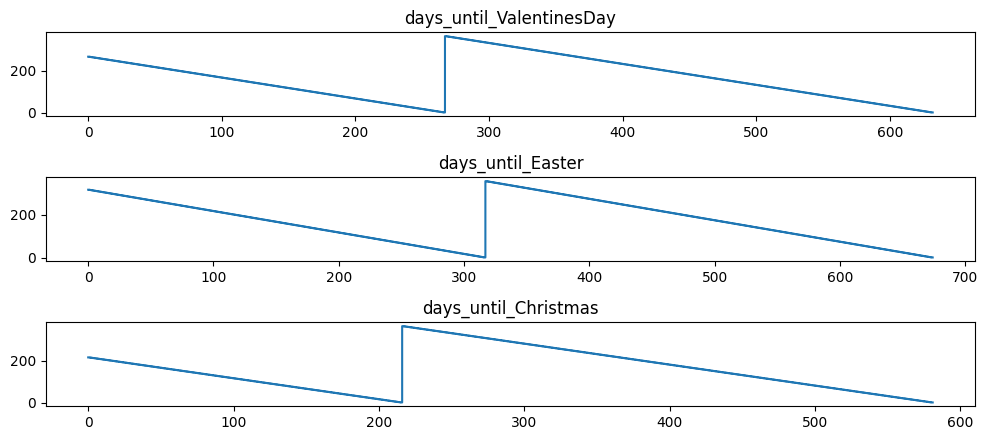

In [ ]:
feature_values, feature_names = create_features_events(sales, calendar)
plot_tabular_features(feature_values, ["days_until_ValentinesDay", "days_until_Easter", "days_until_Christmas"], num_steps=365*2)

Let's train a model with them

In [ ]:
# Build the label and features.
dataset = sales
dataset, label_keys, label_horizons = create_labels(dataset)
dataset, feature_lag_sales_keys = create_feature_lag_sales(dataset)
dataset, feature_date_keys = create_features_date(dataset)
dataset, feature_moving_stats_keys = create_feature_moving_stat_all(
    dataset,
    window_lengths=[7, 14, 28, 56],
    operators=["mean", "std"],
    levels=[[STORE, ITEM], [STORE], [ITEM]]
)
dataset, feature_events_keys = create_features_events(dataset, calendar)

# Collect the signals
feature_names = (
    feature_lag_sales_keys +
    feature_date_keys +
    feature_moving_stats_keys +
    feature_events_keys +
    meta_columns
)
dataset = dataset[feature_names + label_keys + [DAY, ID]]

In [ ]:
%%time
gbdt_result_evt = train_direct_gbt_models(
    dataset=dataset,
    feature_names=feature_names,
)

In [ ]:
plot_self_evaluation(gbdt_result_evt)
plot_learning_curve(gbdt_result_evt)

In [ ]:
df_preds_gbdt_evt = parse_gbdt_predictions(gbdt_result_evt)
df_preds_gbdt_evt.head()

In [ ]:
results["GBDT_lag_calendar_moving_stats_events"] = round(mean_RMSSE(df_preds_gbdt_evt), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_gbdt_evt)

### Question

1. Why do you think these features don't improve the performance?
> Hint: consider the horizon used.

# Looking at the model

A GBDT is composed of multiple decision trees. While a GBDT is complex to interpret as a whole, looking at the first trees is informative.


In [ ]:
# select the tree to plot
horizon = 6

# plot the first tree of the model predicting the sales `horizon` days in the
# future
tfdf.model_plotter.plot_model_in_colab(
    gbdt_result_mov.models[horizon],
    tree_idx=0,
    max_depth=2
)

### Question

1. Look at the tree above and try to make sense of it.

Note: Re-running the training with slighly different parameters (including EXECUTION_MODE value) can change the exact structure of the learned trees.

We can also look at which tabular feature is the most important to the model using the "variable importances".

In [ ]:
#@title Definition of plot_feature_importances
def get_feature_importances(
    gbdt_result: DirectGBDTResult,
    horizon: int=0,
    metric: str="INV_MEAN_MIN_DEPTH"
) -> pd.DataFrame:
    """Returns a DataFrame with feature importances for the specified model and
    metric.

    Args:
        gbdt_result: A DirectGBDTResult object containing the trained models.
        horizon: The index of the model to get the feature importances for.
            Defaults to -1.
        metric: The metric to use for calculating feature importances. Defaults
            to "INV_MEAN_MIN_DEPTH".

    Returns:
        a DataFrame containing the variable names and their corresponding
            scores, sorted by score in descending order.
    """
    var_scores_dict = {"variable": [], "score": []}
    for (variable, _, _) , score in (
        gbdt_result
        .models[horizon]
        .make_inspector()
        .variable_importances()[metric]
    ):
        var_scores_dict["variable"].append(variable)
        var_scores_dict["score"].append(score)
    return pd.DataFrame(var_scores_dict).sort_values(by="score", ascending=False)

def plot_feature_importances(
    gbdt_result: DirectGBDTResult,
    horizon: int=0,
    metric: str="INV_MEAN_MIN_DEPTH",
    num_feats: int=15,
    figsize: Tuple[int, int]=(6, 10),
) -> None:
    """Plots a bar chart of the top N (num_feats) most important features for
    the specified model and metric.

    Args:
        gbdt_result: A DirectGBDTResult object containing the trained models.
        horizon: The index of the model to get the feature importances for.
            Defaults to -1.
        metric: The metric to use for calculating feature importances. Defaults
            to "INV_MEAN_MIN_DEPTH".
        num_feats: The number of features to plot. Defaults to 15.
        figsize: The size of the figure. Defaults to (6, 10).
    """
    # calculate feature importances
    df_scores = get_feature_importances(
        gbdt_result, horizon=horizon, metric=metric
    ).iloc[:num_feats]

    # create figure
    fig, ax = plt.subplots(figsize=figsize)

    # barplot
    sns.barplot(
        data=df_scores,
        x="score",
        y="variable",
        orient="h",
        color="C0"
    )
    ax.set_xlabel(metric.lower())

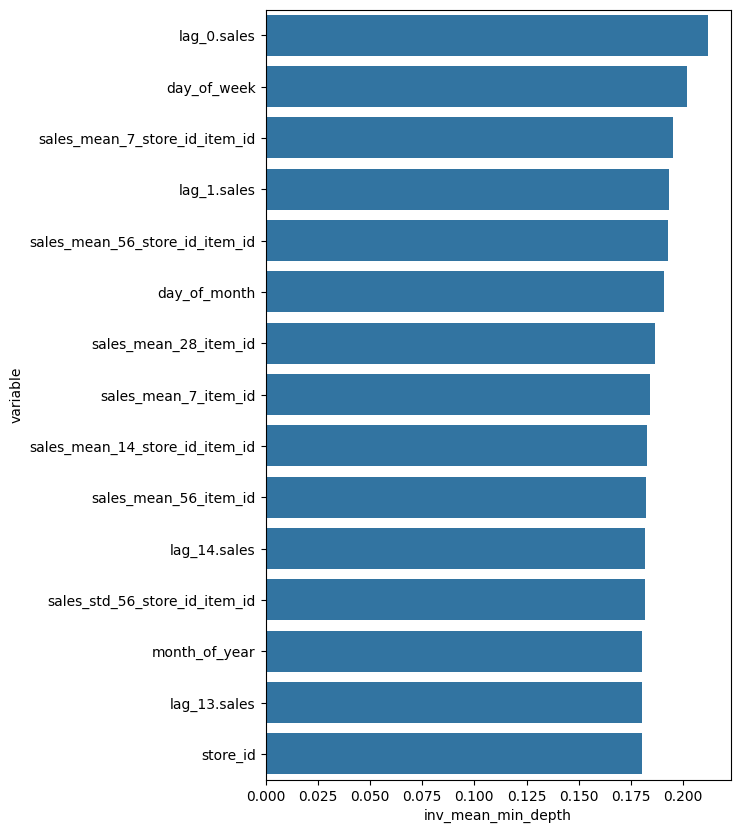

In [ ]:
horizon = 6
plot_feature_importances(gbdt_result_mov, horizon=horizon)

### Questions

1. Can you make sense of the top variable importances?

2. How can you use variable importance to improve your feature engineering?

# Other methods

An overview of some other notable models and techniques we couldn't fit into this codecamp :)

## Models

### Linear models

An improvement on the SARIMA model we used would be to feed exogenous data to it through the `exog` parameter, effectively turning into a [SARIMAX](https://365datascience.com/tutorials/python-tutorials/arimax/) model.

### Neural networks

When dealing with tabular data, an array of deep models becomes available to help us tackle our problem. A simple feed-forward neural network, or multi-layer perceptron, would be the simplest example.

However, if its time series data we need to process, some very specialized models such as [DeepAR](https://arxiv.org/abs/1704.04110) or [Temporal Fusion Transformer](https://arxiv.org/abs/1912.09363) might be best. [This survey](https://arxiv.org/abs/2104.00164) also explains in detail how to apply feed-forward, convolutional and recurrent nets to a forecasting problem.

### Ensembling

Ensembling consists of training several models on the same task, and then using some aggregate of their predictions as our final forecast. Its a simple technique that can greatly improve forecasting robustness, but its compute needs grow as you grow the number of models to be ensembled together, making it hard to demonstrate in this setting.

Notably, the [winner of the M5 competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy/discussion/163684) used an ensemble of several different LGBM models (similar gradient boosting model to the one we used in this notebook) trained at different hierarchical levels (store level, store-category level, etc.) and with recursive and non-recursive approaches.

The [M5 results paper](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions) also stresses the improved accuracy achieved by combining forecasts of different methods.

### Hierarchical forecasting

In this notebook, we focused on forecasting the time series at the lowest possible aggregation level, the item-store one. But what if we also needed to forecast the same horizons for the store level series, and have the store-item forecasts add up to the store ones? This problem is known as [hierarchical forecasting](https://robjhyndman.com/files/3-Hierarchical.pdf).

Two main approaches exist:
- [Single level approaches](https://otexts.com/fpp3/single-level.html), which consist of forecasting on a single hierarchical level and either summing up to obtain the higher level forecasts (bottom-up approach) or breaking up according to historical proportions to obtain the lower level ones (top-down approach).
- [Reconciliation approach](https://otexts.com/fpp3/reconciliation.html), which consists of forecasting all levels of aggregation, and then reconciling the resulting forecasts using least squares optimization.

## Features

### Hierarchical normalization

When creating the moving statistics features, we capitalized on our data's hierarchical structure by feeding the model information not only about a single item-store series' past behavior, but also about the corresponding store's and item's one. In the same way, we could have for example used the values of a higher levels time series to **normalize** the values of the one we're trying to predict.

## Validation

### Temporal cross validation

If wanting to use cross-validation to obtain more robust metrics on our models, we need to be extra careful if dealing with time series data. In a normal setting, a cross validation split would mean taking N couple equally-sized _random_ chunks of our dataset, and iterating over using N-1 chunks for training and the remaining one for validation.

However, in a time series setting, taking random samples of the data will most likely lead to having data in the training set that is in the future of the data in the validation set - that's known as _future leakage_, and something you want to avoid at all costs. [Sklearn's TimeSeriesSplit](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#time-based-cross-validation) can come in handy to achieve a time-sensitive cross validation that ensures the validation data to always be in the future of the training one.

# Conclusions

In this notebook, we introduced the concept of time series forecasting.

We went over the fundamental steps to take when preparing data for time series forecasting, mainly tabularization and feature engineering. We trained and evaluated three different models, with varying degrees of performance and complexity, with the goal of predicting the next 7 days’ sales for a subset of stores and items. We also demonstrated how to calculate different types of features and measured their impact on the model's performance.

Our results show that the more complex models, which included features such as calendar information, moving statistics, and special events, outperformed the simpler models. Specifically, the GBDT model with all of these features had the lowest average root mean scaled squared error on the selected subset of the dataset, which suggests that Machine Learning models greatly benefit from different families of features.

Our goal was to equip you with practical skills and tools that can scale to other forecasting problems, not just next 7 days’ sales prediction. We hope that you found this code camp both informative and engaging, and that you feel empowered and motivated to apply these skills in your future work.

As a final note, we greatly encourage you to re-run the notebook with the full configuration mode, which involves using the entire dataset and a much more powerful model. You can also play around with the code, hyper-parameters, other models, and calculate even more features to see how high you can get on the Kaggle leaderboard!

Thank you for your participation!



# Temporian

As you might have noticed, doing some of this feature engineering with pandas is both slow to code, and slow to run! This isn't pandas' fault - it just isn't especially tailored to work with time series data.

For some months now, we at Tryolabs and Google have been working together to create **a tool to make preprocessing and feature engineering for time series easier** for everyone, called **[Temporian](https://github.com/google/temporian)**!

You are more than welcome to take a look and spread the word - its still in its early stages, but we're planning on doing our first public release soon.

As a spoiler, this is what creating the `feature_lag_sales` and `feature_moving_stats` would look like using `temporian` ;)

```python
import temporian as tp

# Load raw data
event = tp.read_event(
  "sales_train_evaluation.csv",
  index=["id"],
).schema()

# Compute temporal features
sma = tp.simple_moving_average(
    event["sales"],
    window_length=tp.day(5),
)

lag = tp.lag(
    event["sales"],
    lag=tp.week(1),
)
```

# Further reading

If you want to delve deeper into the world of time series forecasting, be sure to visit [this](https://github.com/cuge1995/awesome-time-series) repository. You'll find a wealth of resources on time series, including datasets, papers on the latest forecasting algorithms, useful libraries for working with time series, and more.

The repository was curated by the winner of the M5 competition, so you can be confident that it's a treasure trove of time series knowledge!
It's also worth noting that this repository is constantly updated with the latest resources.

Other resources we recommend include:
- [This](https://otexts.com/fpp3/) online textbook by Rob J Hyndman and George Athanasopoulos
- [This](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions) publication showcasing the results, conclusions and main findings of the M5 challenge
- [This](https://arxiv.org/abs/2012.03854) theorical and practical guide to Forecasting. It was last updated on January of 2022.
- [This](https://arxiv.org/abs/2104.00164) recent survey on Time Series Forecasting.






## Feedback Code Camp
We would really appreciate if you can take a moment to **fill this quick survey**: https://forms.gle/sQvVdGtPwYwEFkXG6.

Thank you for your feedback!

# Appendix

## Note on linear interpolation and TS plotting

Plotting temporal data using lines to connect the points makes readable plots. However, such plot can be deceptive as visually, the data is leaked into the past by one step:

Suppose a time series indexed by integers. If $t \in \mathbb{N}$, the value plotted at time $t+0.1$ is a weighted average of the data points $s[t]$ and $s[t+1]$. Specifically, the value at $t+0.1$ is a calculated as:

$0.9 \cdot s[t] + 0.1 \cdot s[t+1]$.

This means that the plotted value at time $t+0.1$, relies on the data available at time $t+1$.

When handling datasets with non-uniform sampling, it is recommended to use right-aligned stairs instead of linear interpolation. In the other case, just be mindful. For easier visualization, we will make use of the interpolated plot variant during this codecamp.

The following figure shows an example of good and bad plots of temporal data.

In [ ]:
#@title
xs, ys = [0, 3, 4, 5, 6, 7], [0, 1, 1, 0.1, 0.2, 0.9]

plt.subplot(1, 2, 1)
plt.plot(xs,ys)
plt.scatter(xs,ys, color="red")
plt.title("Wrong")
plt.annotate("This value is\n impacted by s[3]", xy=(1.5, 0.5), xytext=(-0.1, 0.8), arrowprops=dict(arrowstyle="->"))

plt.subplot(1, 2, 2)
plt.step(xs,ys, where="post")
plt.scatter(xs,ys, color="red")
plt.title("Right")

plt.show()

## Note on transactional data

While time series is a popular data representation for forecasting problems, it is not the only one. Transactional data is another common temporal data representation.

A transactional dataset is composed of a set of transactions, where each transaction is attached to a timestamp and some other data (e.g. numerical, categorical, text, images, and other timestamps).

For example, sales records in a shop are represented as transactional data.

| timestamp        | item name | item id   | price | offer | cashier | store |
|------------------|-----------|-----------|-------|-------|---------|-------|
| 03/02/2023 10:50 | bread     | #98701246 | 0.95  |       | 11      | CA#1  |
| 03/04/2023 17:21 | beer pack | #43256435 | 8.95  | 20%   | 5       | PA#5  |

It is common to aggregate transactional data into time series data. For example, in this practical, we will predict daily aggregated (by store and item) sales records:

| timestamp  | item name | item id   | num sales | sum sales | store |
|------------|-----------|-----------|-----------|-----------|-------|
| 03/02/2023 | bread     | #98701246 | 16        | 15.20     | CA#1  |
| 03/03/2023 | bread     | #98701246 | 24        | 22.8      | PA#5  |
| 03/04/2023 | bread     | #98701246 | 8         | 7.6       |       |

While some methods can operate on transactional data directly, we won't convert them in this practice.
